In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

## Toy example

In [7]:
class ResidualVGG(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ResidualVGG, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, (3,3), padding=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, (3,3), padding=1, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv1x1 = nn.Conv2d(in_channels, 64, (1,1), padding=0, stride=1)
        
    def forward(self, _x):
        x = self.conv1(_x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x_res = self.conv1x1(_x)
        x = x + x_res
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        
        
        
        return x

In [8]:
model = ResidualVGG(1, 7)
model

ResidualVGG(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
)

In [9]:
out = model(torch.rand(12, 1, 40,40))
out.size()

torch.Size([12, 128, 40, 40])

## Dataset

In [2]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))
#             X = torch.cat([X,X,X], dim=0)

        return X, y

In [3]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Visualize cor and cor feature

The purpose of visualizng the cor and cor. feature in FeatureAct layers is to observe the behavior of the attention. Whether the layer effectively has the good performance or not

In [4]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))

        cor = self.att_act(cor)
    
        # ADDITIONAL CUSTOM
#         cor = cor.sigmoid()
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
#         # ADDITIONAL CUSTOM
#         cor_feature = cor_feature.sigmoid()
        
        x = x + cor_feature
        
        return x

In [5]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [6]:
# activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook


In [7]:
model = torch.load('featureactv4_baseline_model.pt')
model = model.cpu()
model.eval()

activation = {}
model.fact0.register_forward_hook(get_activation('fact0'))
model.fact0.up_depth.register_forward_hook(get_activation('cor_feature0'))
model.bn0b.register_forward_hook(get_activation('bn0b'))

In [8]:
model

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [9]:
images, labels = iter(train_loader).next()
images.size(), labels.size()

(torch.Size([128, 1, 48, 48]), torch.Size([128]))

In [14]:
activation = {}

outs = model(images)

In [11]:
batch_id = 0

tensor(4)
tensor(4)


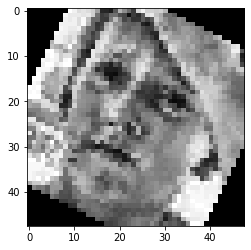

In [15]:
print(labels[batch_id])
print(outs[batch_id].argmax())
plt.imshow(images[batch_id][0], cmap='gray')

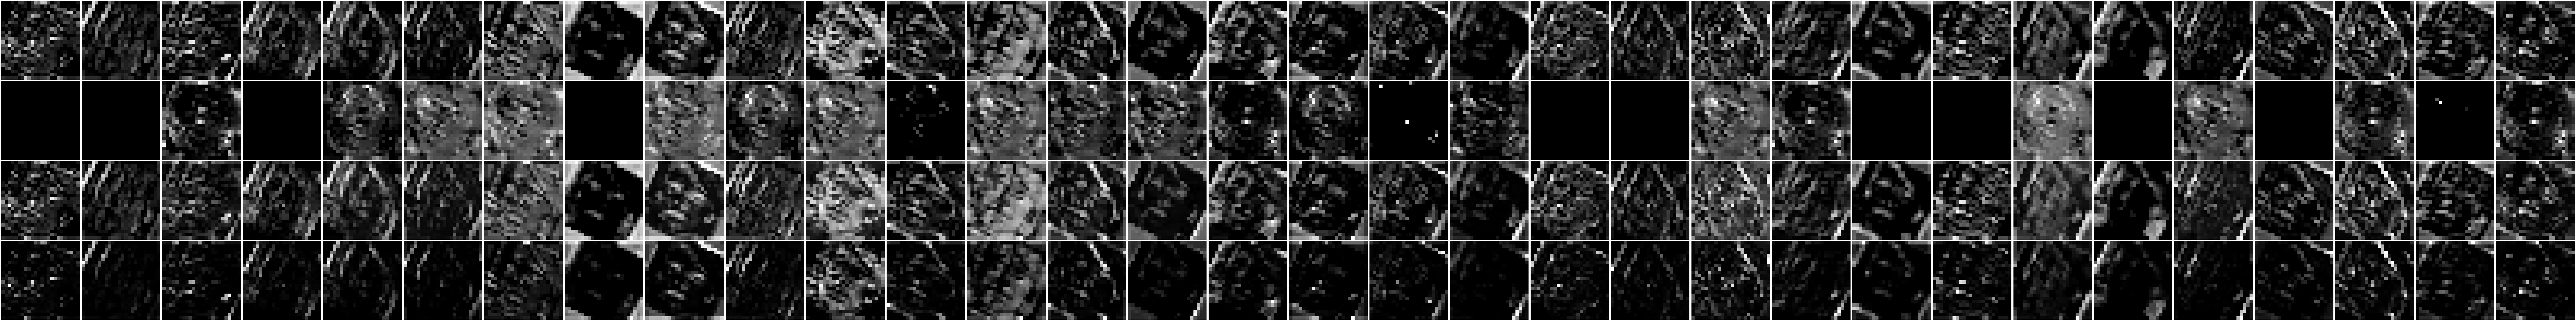

In [17]:
%matplotlib inline

jet_mode = False

features = nn.MaxPool2d(kernel_size=2, stride=2)(nn.ReLU()(activation['bn0b']))
fact = activation['fact0']
# cor_feature = activation['cor_feature0']
cor_feature = activation['cor_feature0'].sigmoid()
masks = [features[i] * fact[i] for i in range(features.size(1))]

# titles = ['features', 'cor_feature', 'fact']

combines = [features, cor_feature, fact, masks]

# batch_id = 0
rows = len(combines)
cols = features.size(1)
fig, axs = plt.subplots(rows, cols, figsize=(features.size(2)*8, features.size(3)))

for i, _feature in enumerate(combines):
#     print(titles[i])
    for j in range(cols):
#         try:
        _img = _feature[batch_id][j]
#         axs[i,j].imshow(_img, cmap='gray')
        if jet_mode:
            _img = np.uint8(_img*255)
            _img = cv2.applyColorMap(_img, cv2.COLORMAP_JET)
            _img = _img[:,:,::-1]
            axs[i,j].imshow(_img)
        else:
            axs[i,j].imshow(_img, cmap='gray')

        axs[i,j].axis('off')
    
    fig.show()


plt.tight_layout()
# plt.savefig("images/back0_wo_activation.png")
plt.show()


In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

def attention(model, img, lb=None, visual_heatmap=True, ext_output=False, grayscale=True, return_heatmap=False):
    model.eval()
    if ext_output:
        output, _ = model(img.unsqueeze(0))
    else:
        output = model(img.unsqueeze(0))
    prob = nn.Softmax()(output.detach())
    prob = float(prob.max(1)[0][0])
    
    
    pred_lb = int(output.argmax(1)[0])
    
    lb = pred_lb if lb is None else lb
    output[:,lb].backward()

    # get gradient
    grads = gradients['last_conv'][0]
    
    # !!! 2 options
#     pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # get activation
    features = activation['last_conv']

    # weight the channels by corresponding gradients
    print('features: ', features.size())
    print('pooled grads: ', pooled_grads.size())
    
    for i in range(features.size(1)):
        features[:, i, :, :] *= pooled_grads[0,i,:,:]
   
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
 
    # 1 channel
    if grayscale:
        img = img.numpy()[0]
        img = np.stack((img,)*3, axis=-1)
        
    # 3 channels
    else:
        img = img.numpy().transpose((1,2,0))
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    heatmap = heatmap[:,:,::-1] #bgr -> rgb
    
    superimposed_img = heatmap * 0.008 + img # here 0.4 is the heat map intensity factor
        
    superimposed_img /= np.max(superimposed_img)
    
    if not return_heatmap:    
        return superimposed_img, pred_lb, int(lb), prob
    
    else:
        return superimposed_img, pred_lb, int(lb), prob, heatmap



In [133]:
# activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook


## Transfer learning with VGG16 backbone combined with FeatureAct layers

### full VGG16 backbone

In [48]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [49]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(64)
        self.bn0b = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn1b = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2c = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn2b = nn.BatchNorm2d(256)
        self.bn2c = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn3b = nn.BatchNorm2d(512)
        self.bn3c = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
        self.bn4c = nn.BatchNorm2d(512)
  
        self.fact0 = FeatureAct(64, 4)
        self.fact1 = FeatureAct(128, 4)
        self.fact2 = FeatureAct(256, 4)
        self.fact3 = FeatureAct(512, 4)
        self.fact4 = FeatureAct(512, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        x = self.conv2c(x)
        x = self.bn2c(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        x = self.conv3c(x)
        x = self.bn3c(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = self.conv4(x3)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv4b(x)
        x = self.bn4b(x)
        x = self.relu(x)
        x = self.conv4c(x)
        x = self.bn4c(x)
        x = self.relu(x)
        
        x4 = self.maxpool(x)
        x4 = self.fact4(x4)
        
        x = nn.Flatten()(x4)
        x = self.classifier(x)
        
        return x

In [50]:
model = torch.load('featureactv34_vgg16pretrained_full_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2c): Conv2d(256, 256

In [51]:
activation = {}
gradients = {}


# print(model)

model.bn4c.register_forward_hook(get_activation('last_conv'))
model.bn4c.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)
(48, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


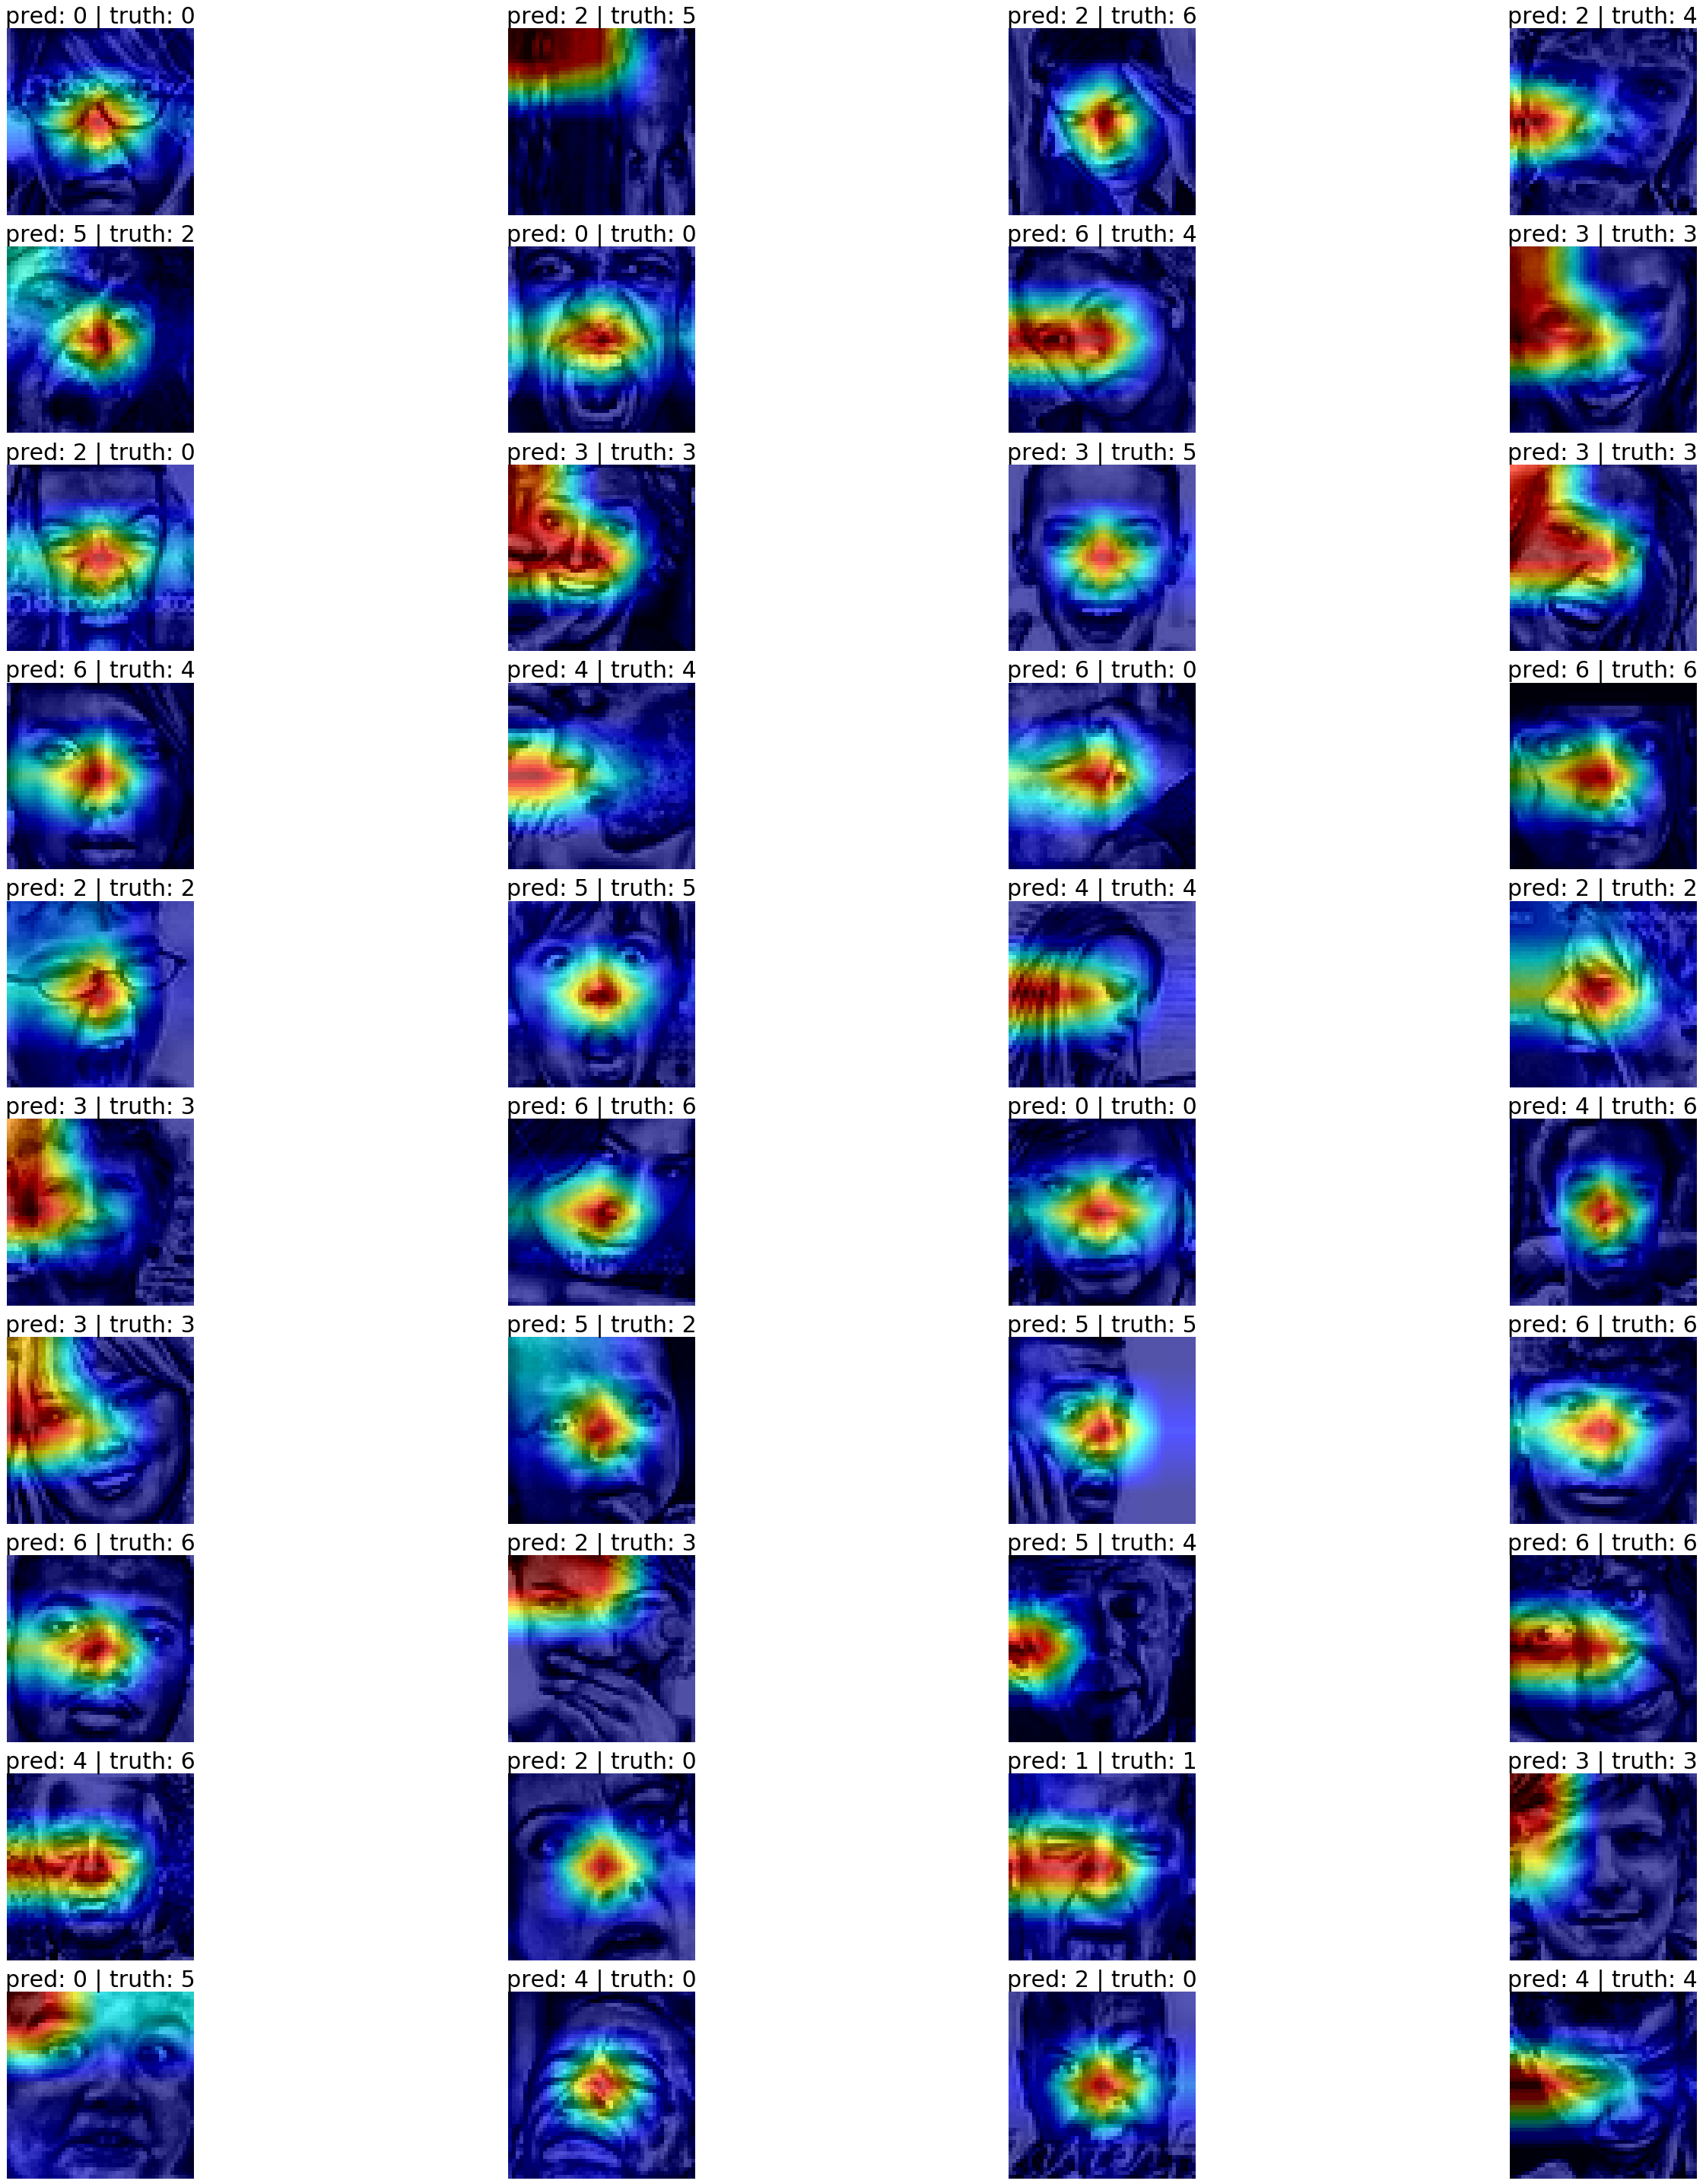

In [52]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## v3.4 + l2 + softmax

In [6]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [8]:
model = torch.load('../Mar_2021/featureactv34_baseline_modelv22.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [9]:
activation = {}
gradients = {}


# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

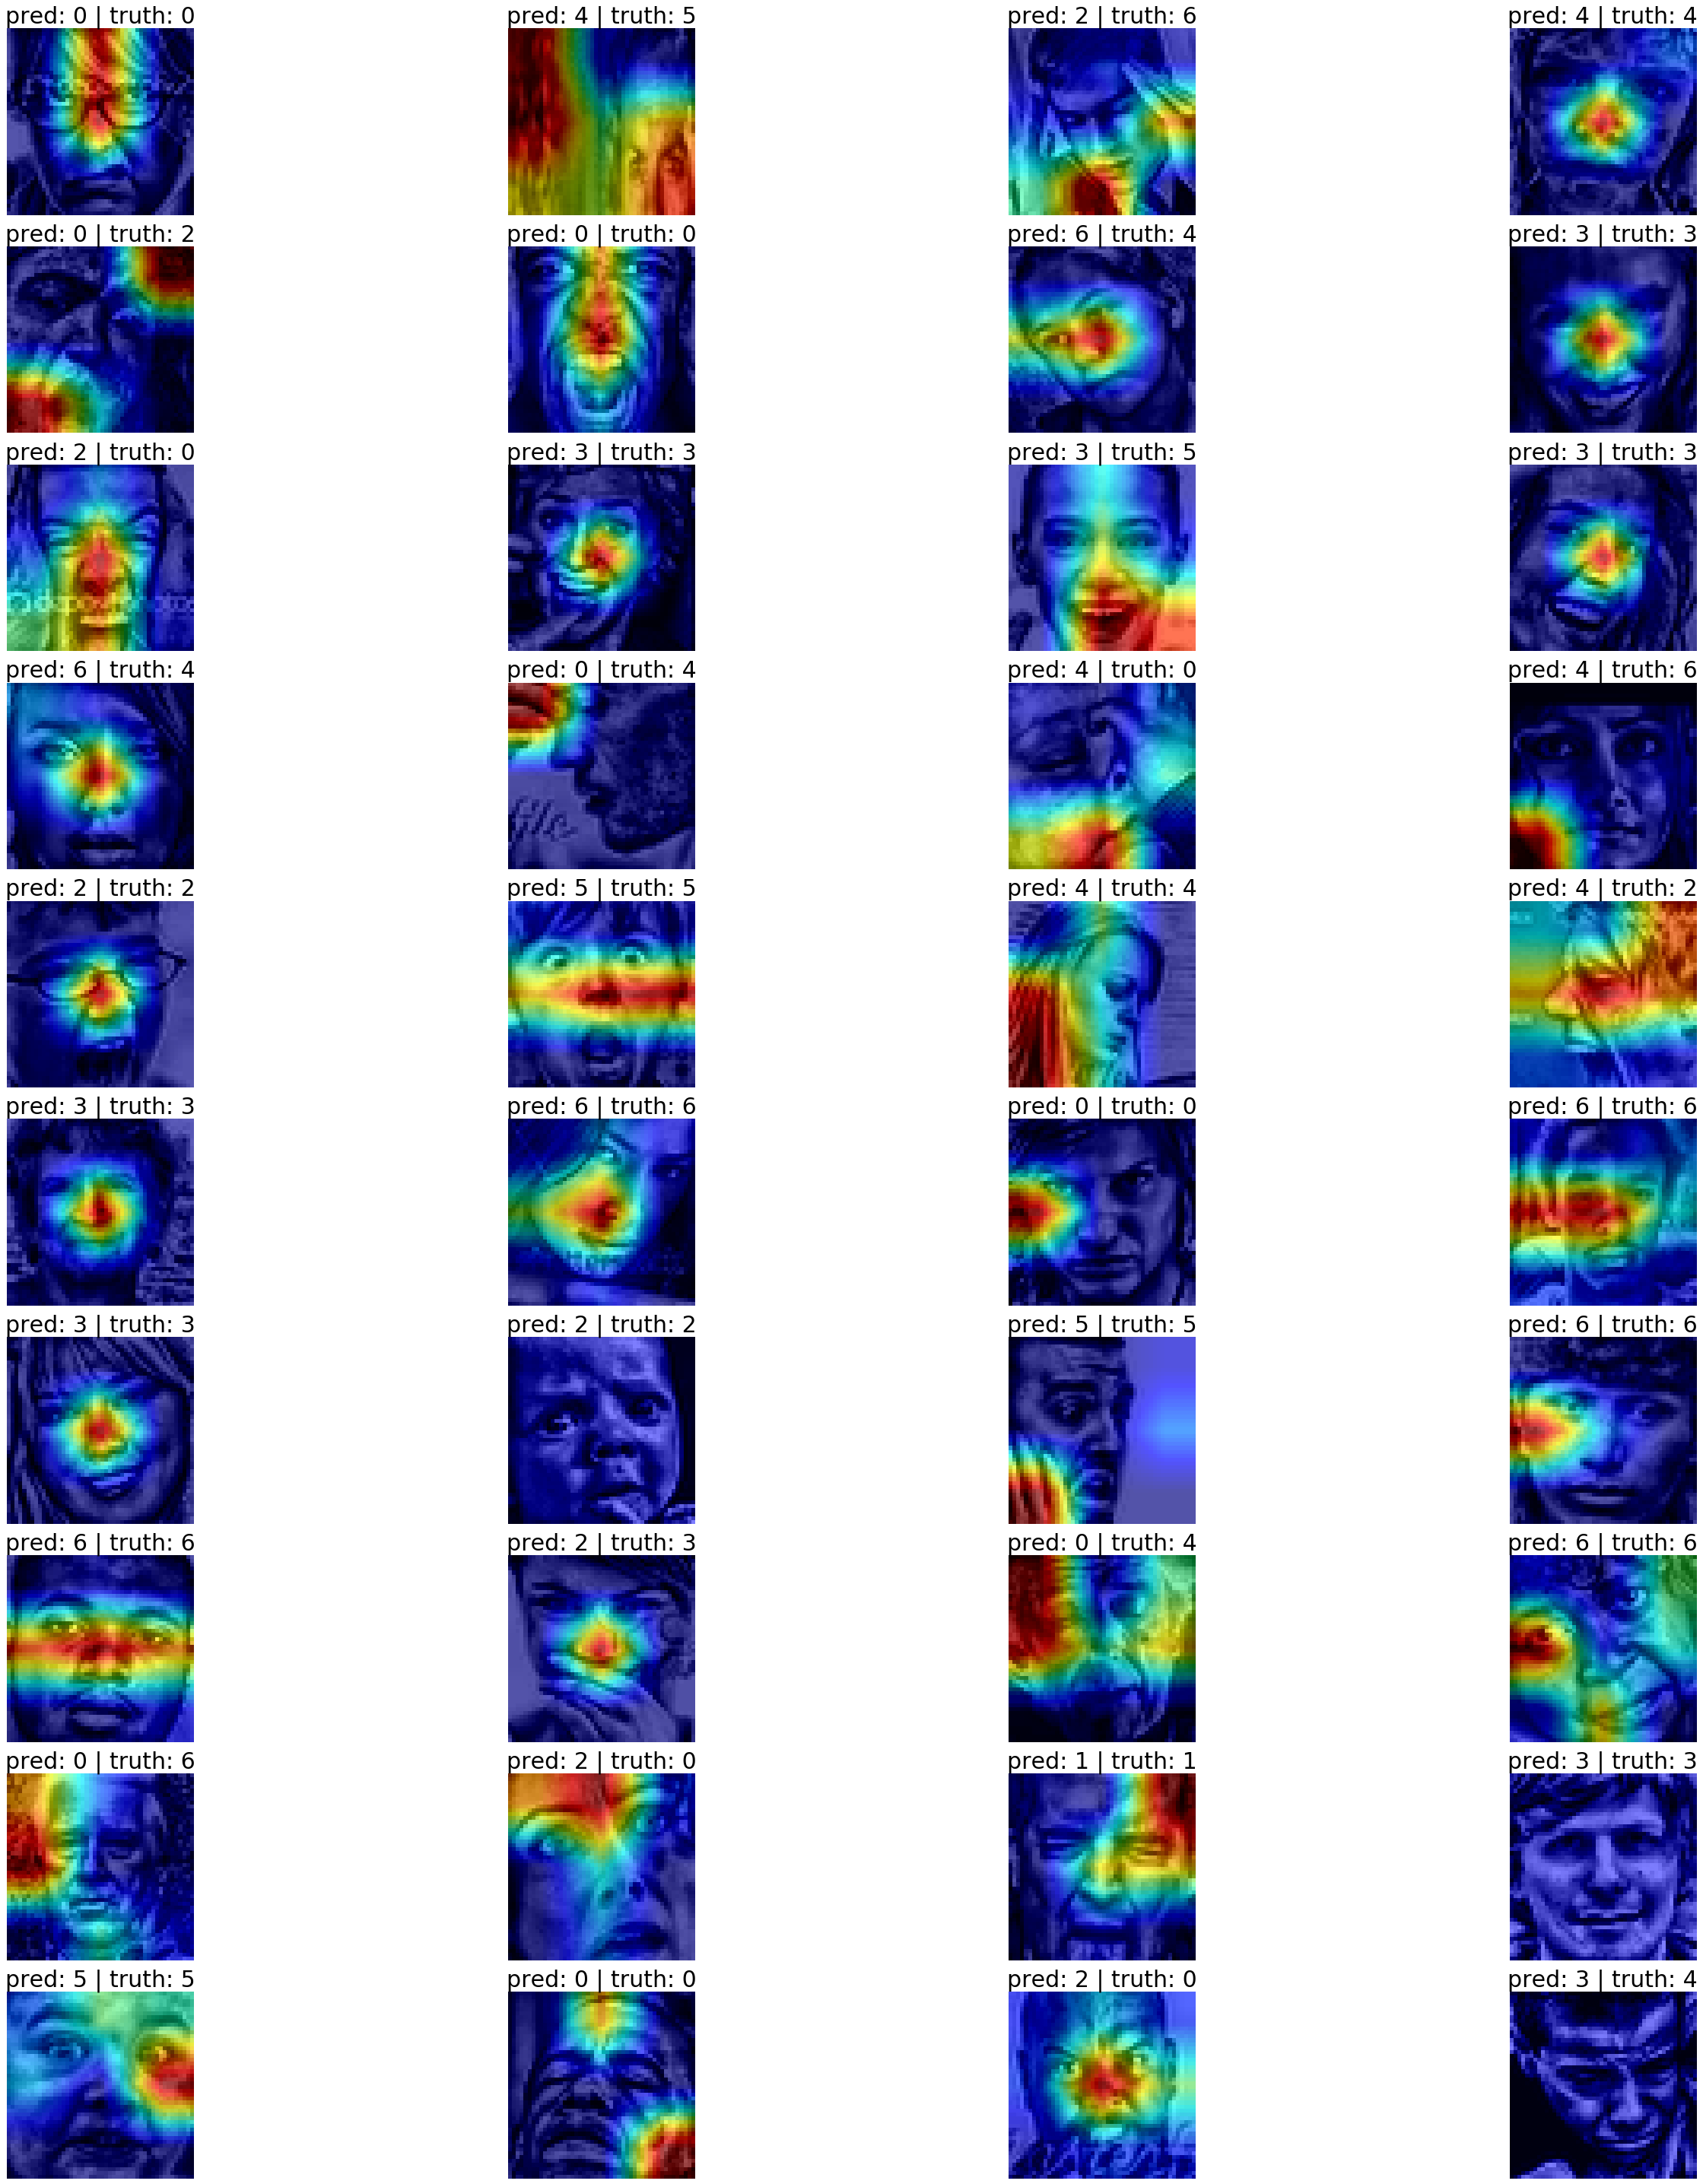

In [10]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## v4

In [19]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))

        cor = self.att_act(cor)
    
        # ADDITIONAL CUSTOM
#         cor = cor.sigmoid()
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
#         # ADDITIONAL CUSTOM
#         cor_feature = cor_feature.sigmoid()
        
        x = x + cor_feature
        
        return x

In [20]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [21]:
model = torch.load('featureactv4_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [22]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

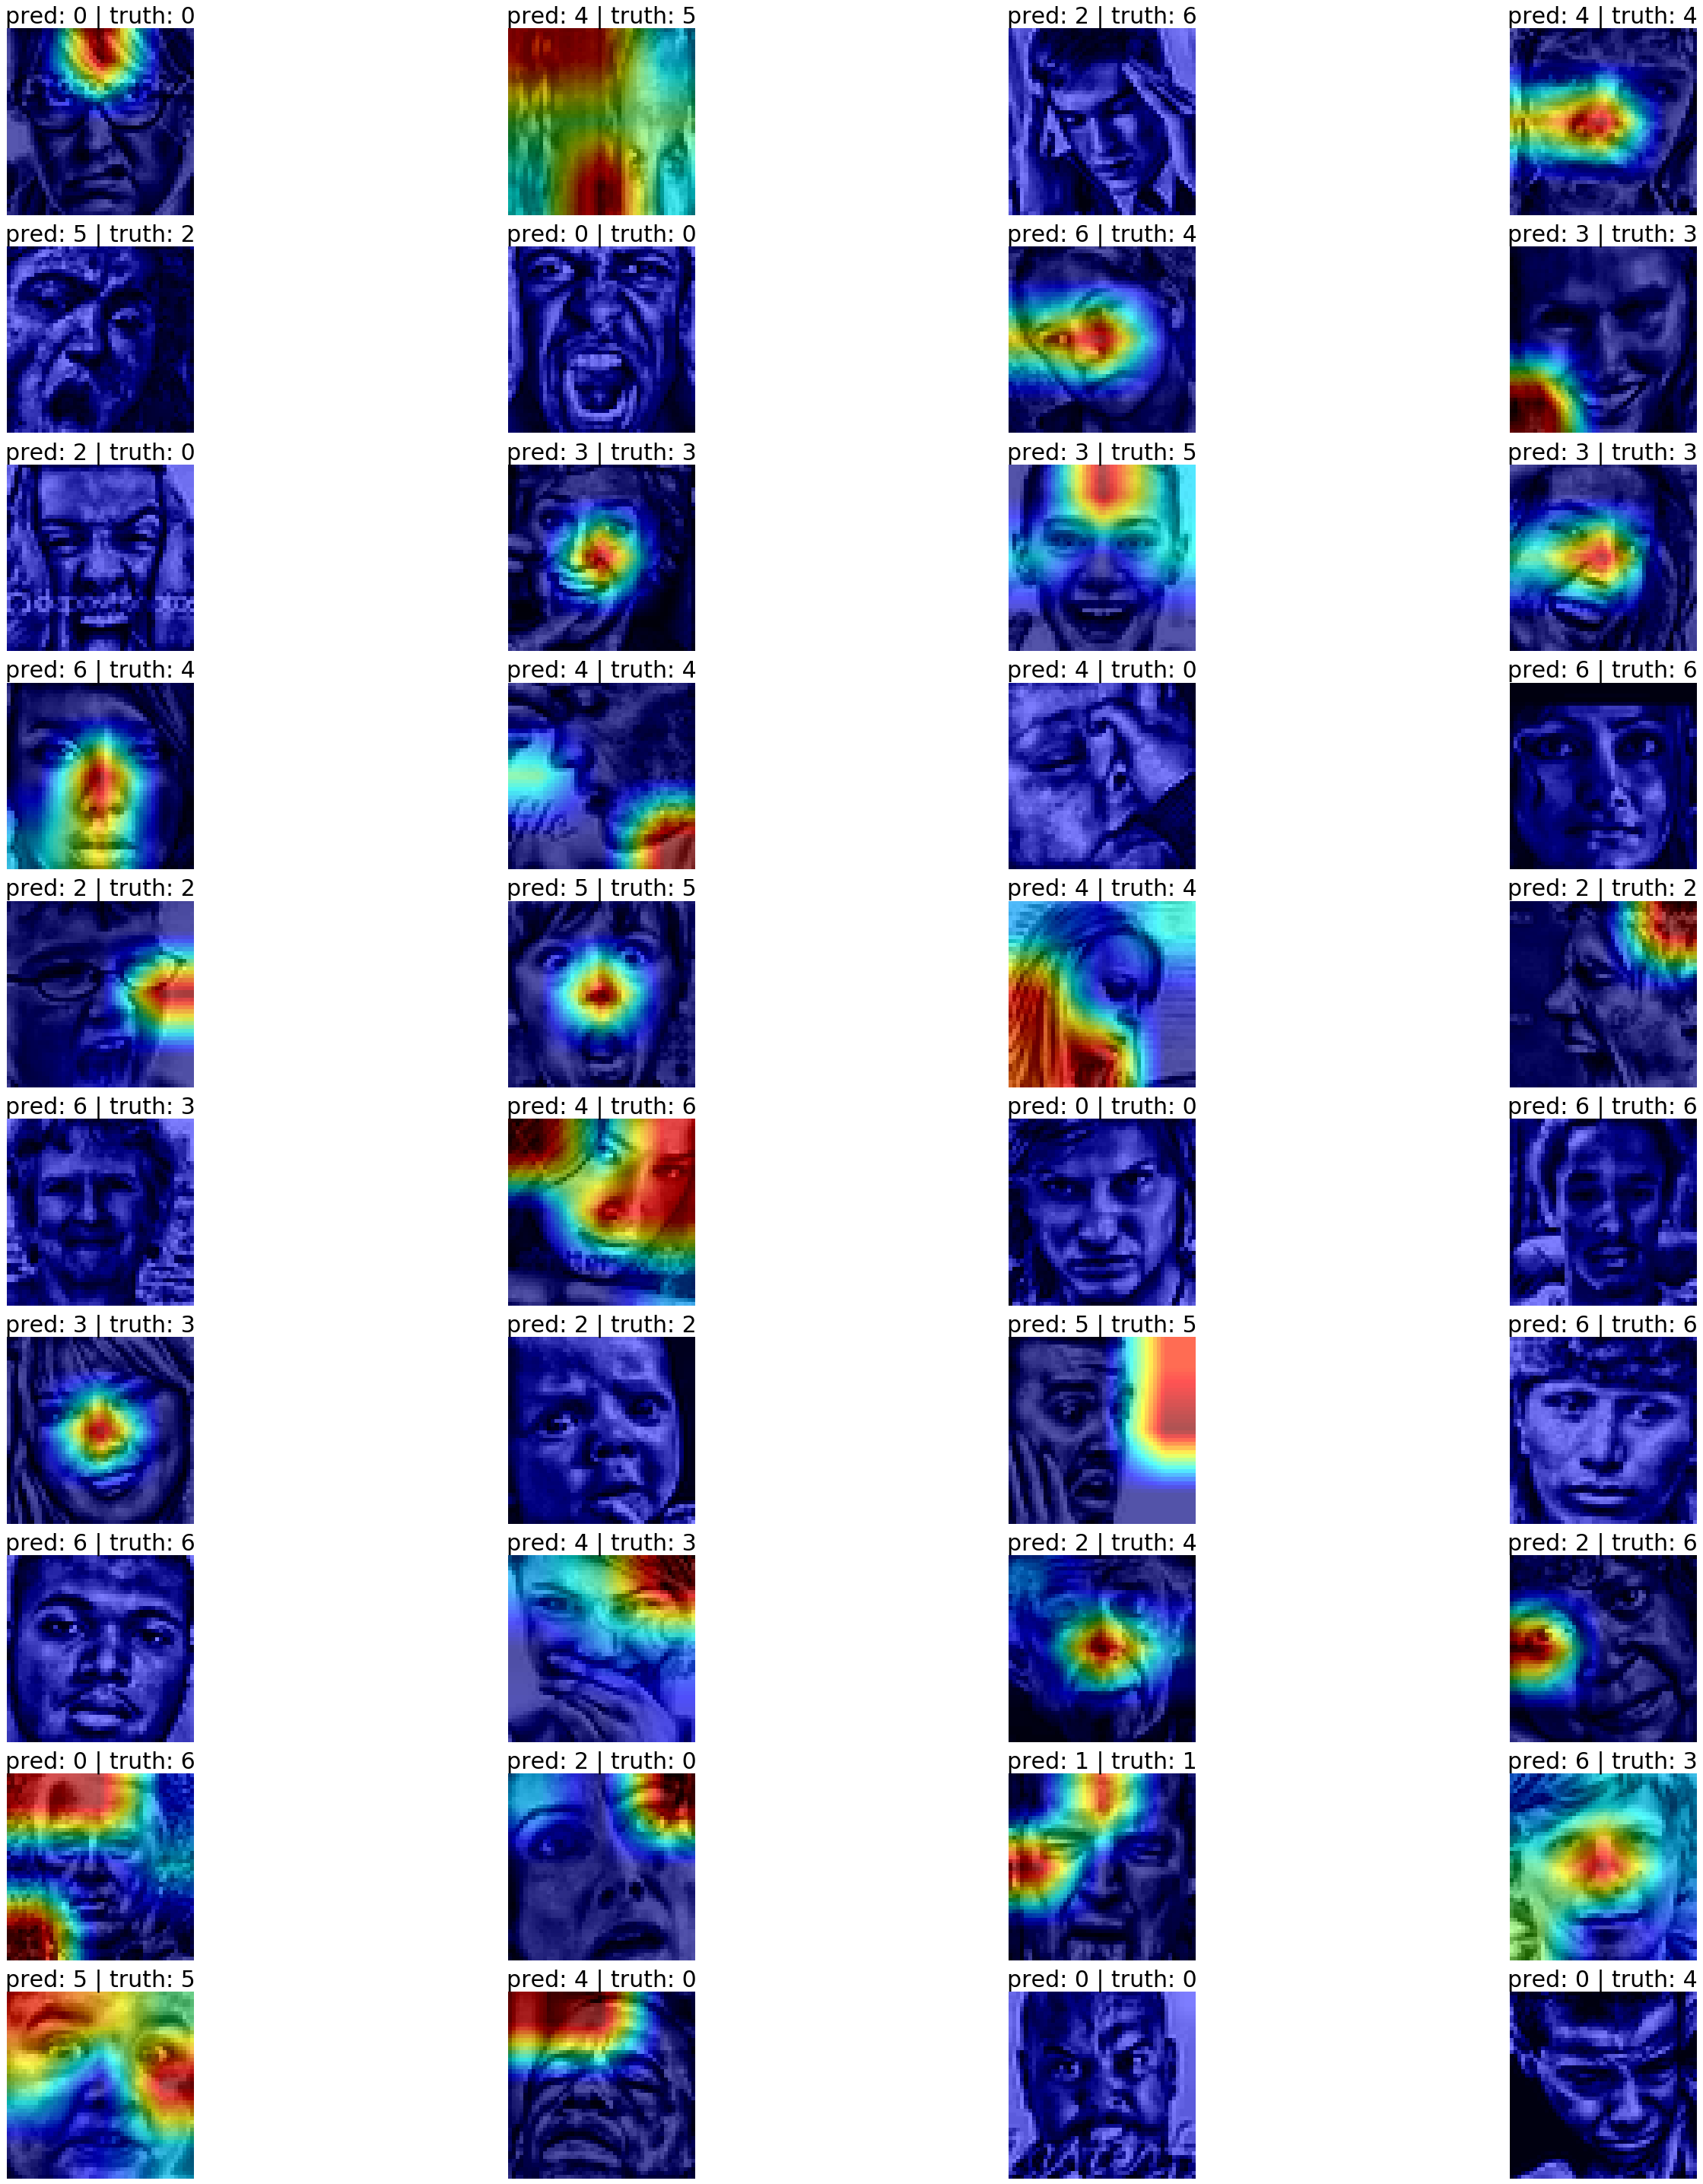

In [23]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## v4.1

In [183]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))
#         cor = self.softmax(cor)
        cor = self.att_act(cor)
        
        main_features = self.down_depth(x)
    
#         cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = torch.cat([((main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) / self.dim) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [184]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [185]:
model = torch.load('featureactv41_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [186]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

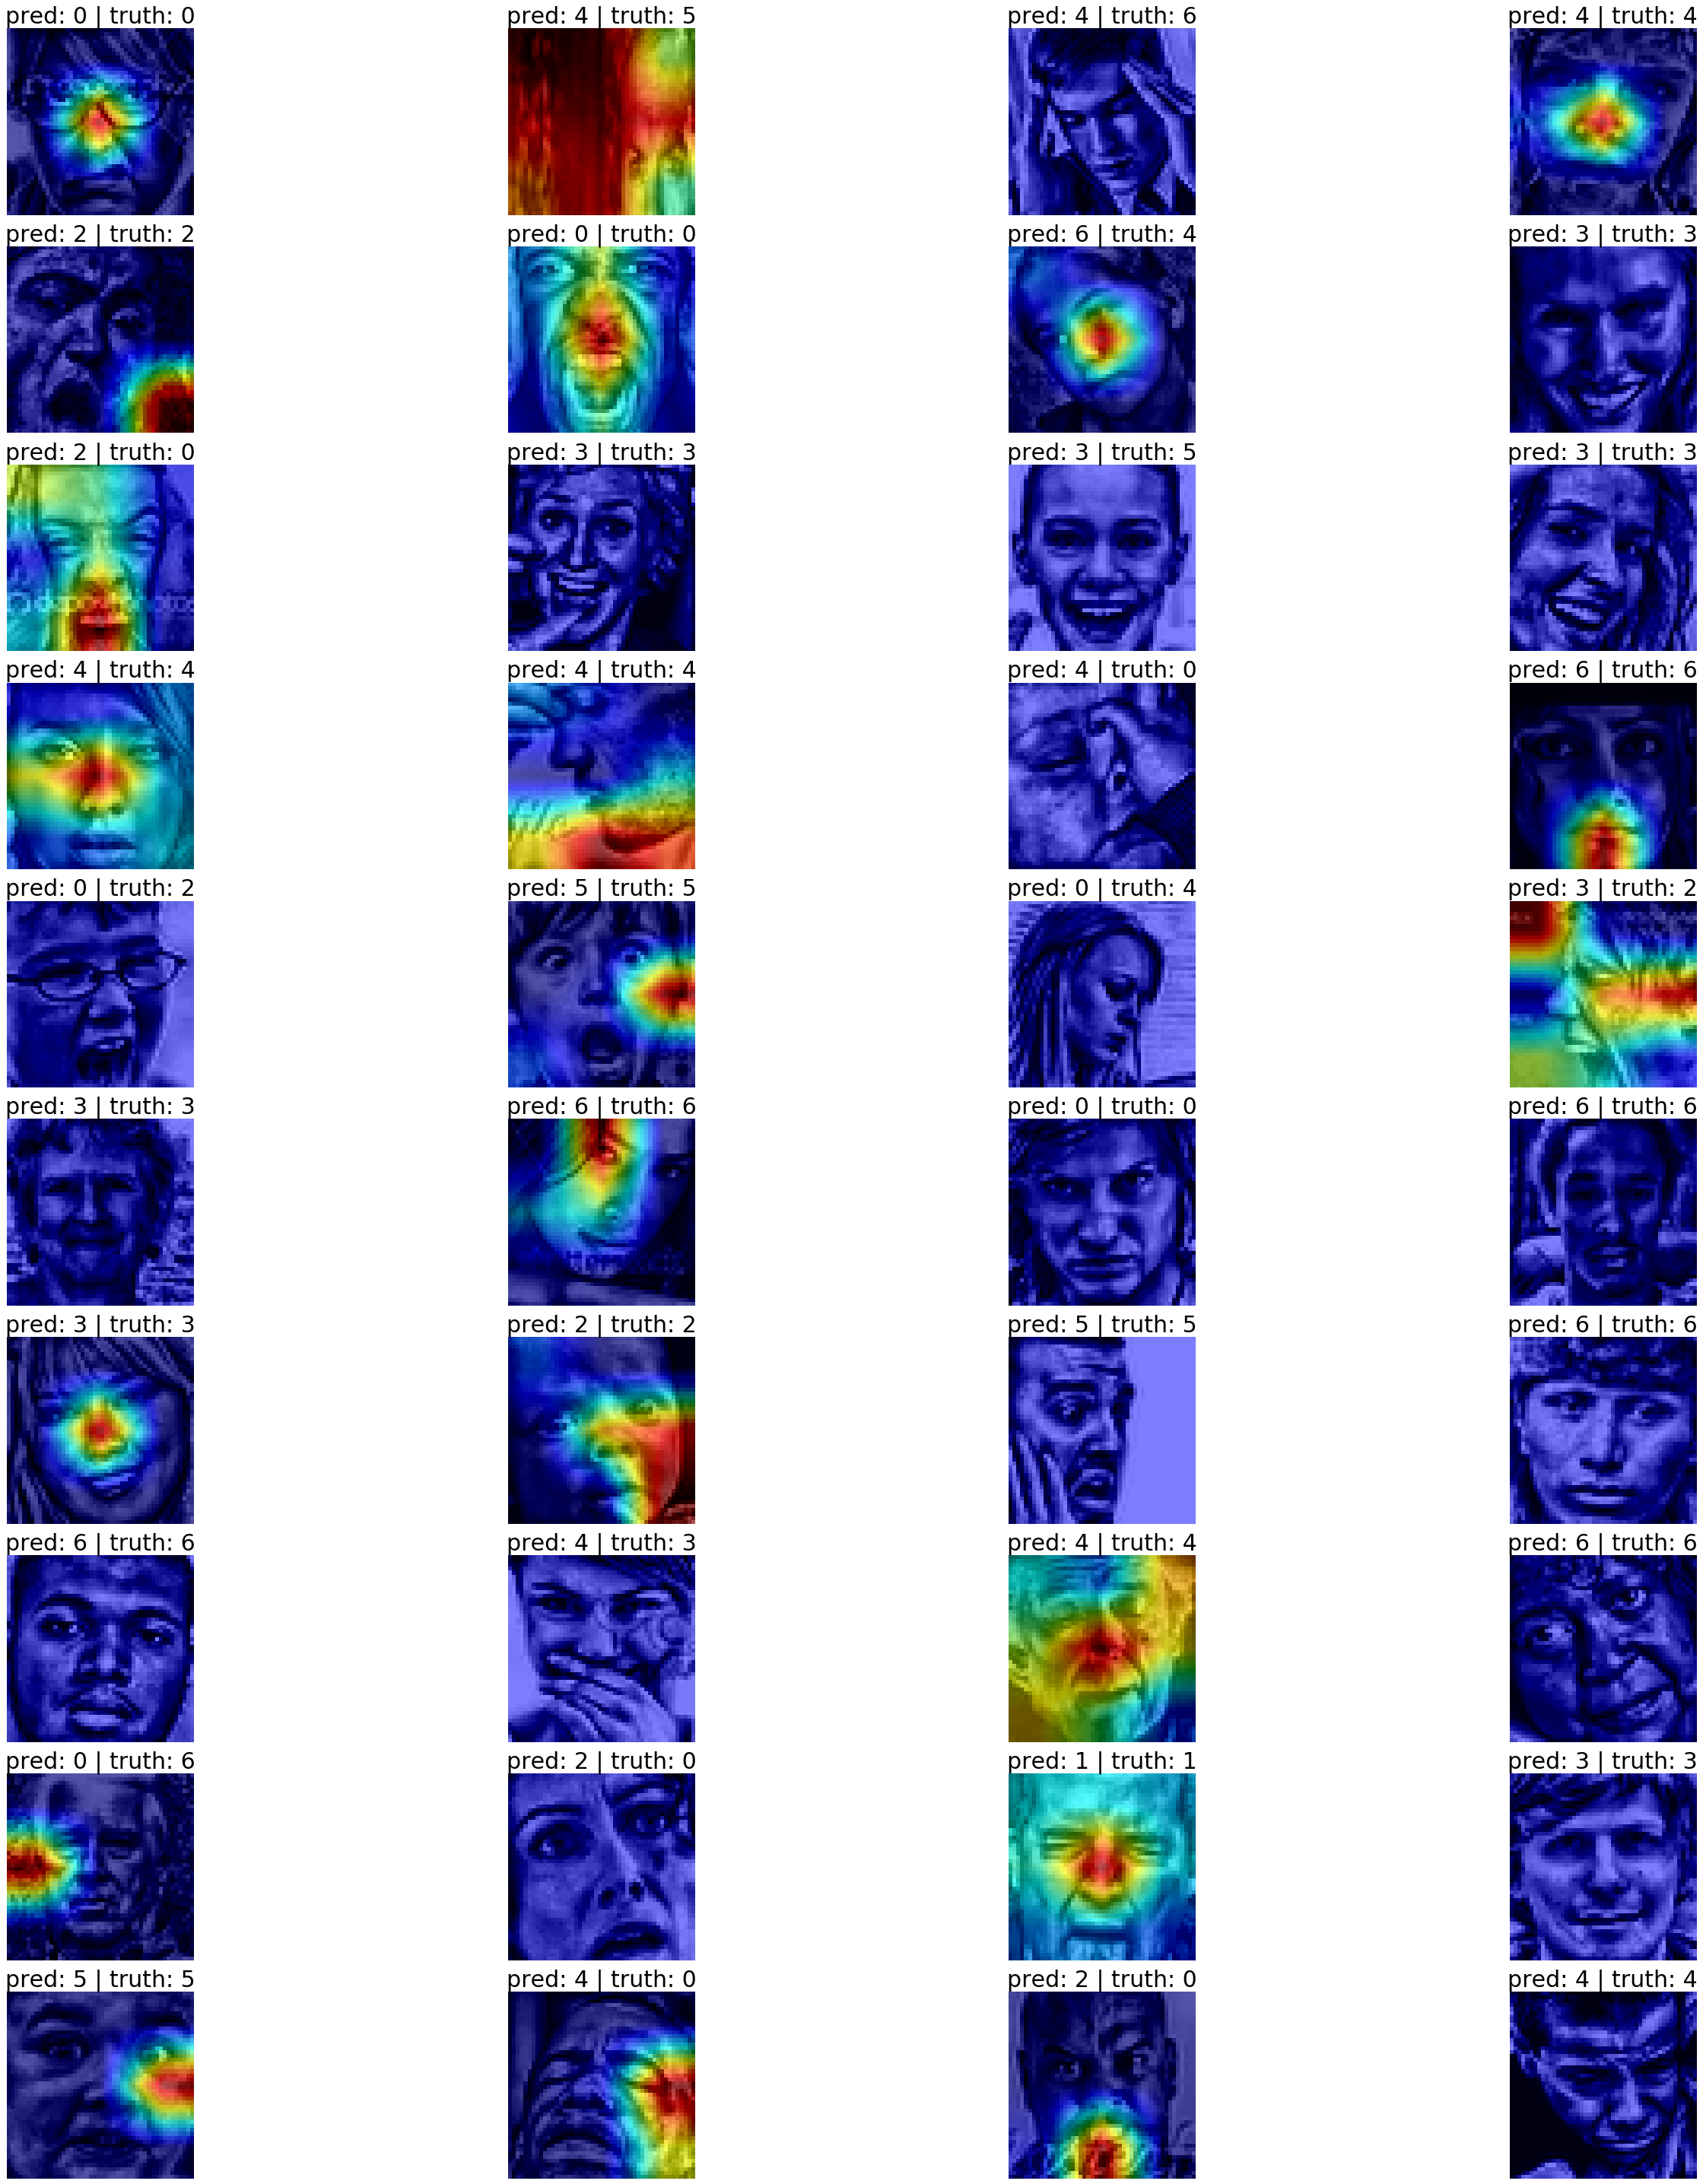

In [187]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## v4 whatever

In [188]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Conv2d(self.dim, self.dim, kernel_size=1, padding=False),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))
        cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting
    
        cor_feature = torch.cat([(main_features * self.norm_conv(cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size))).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [189]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [190]:
model = torch.load('featureactv4_whatever_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [191]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

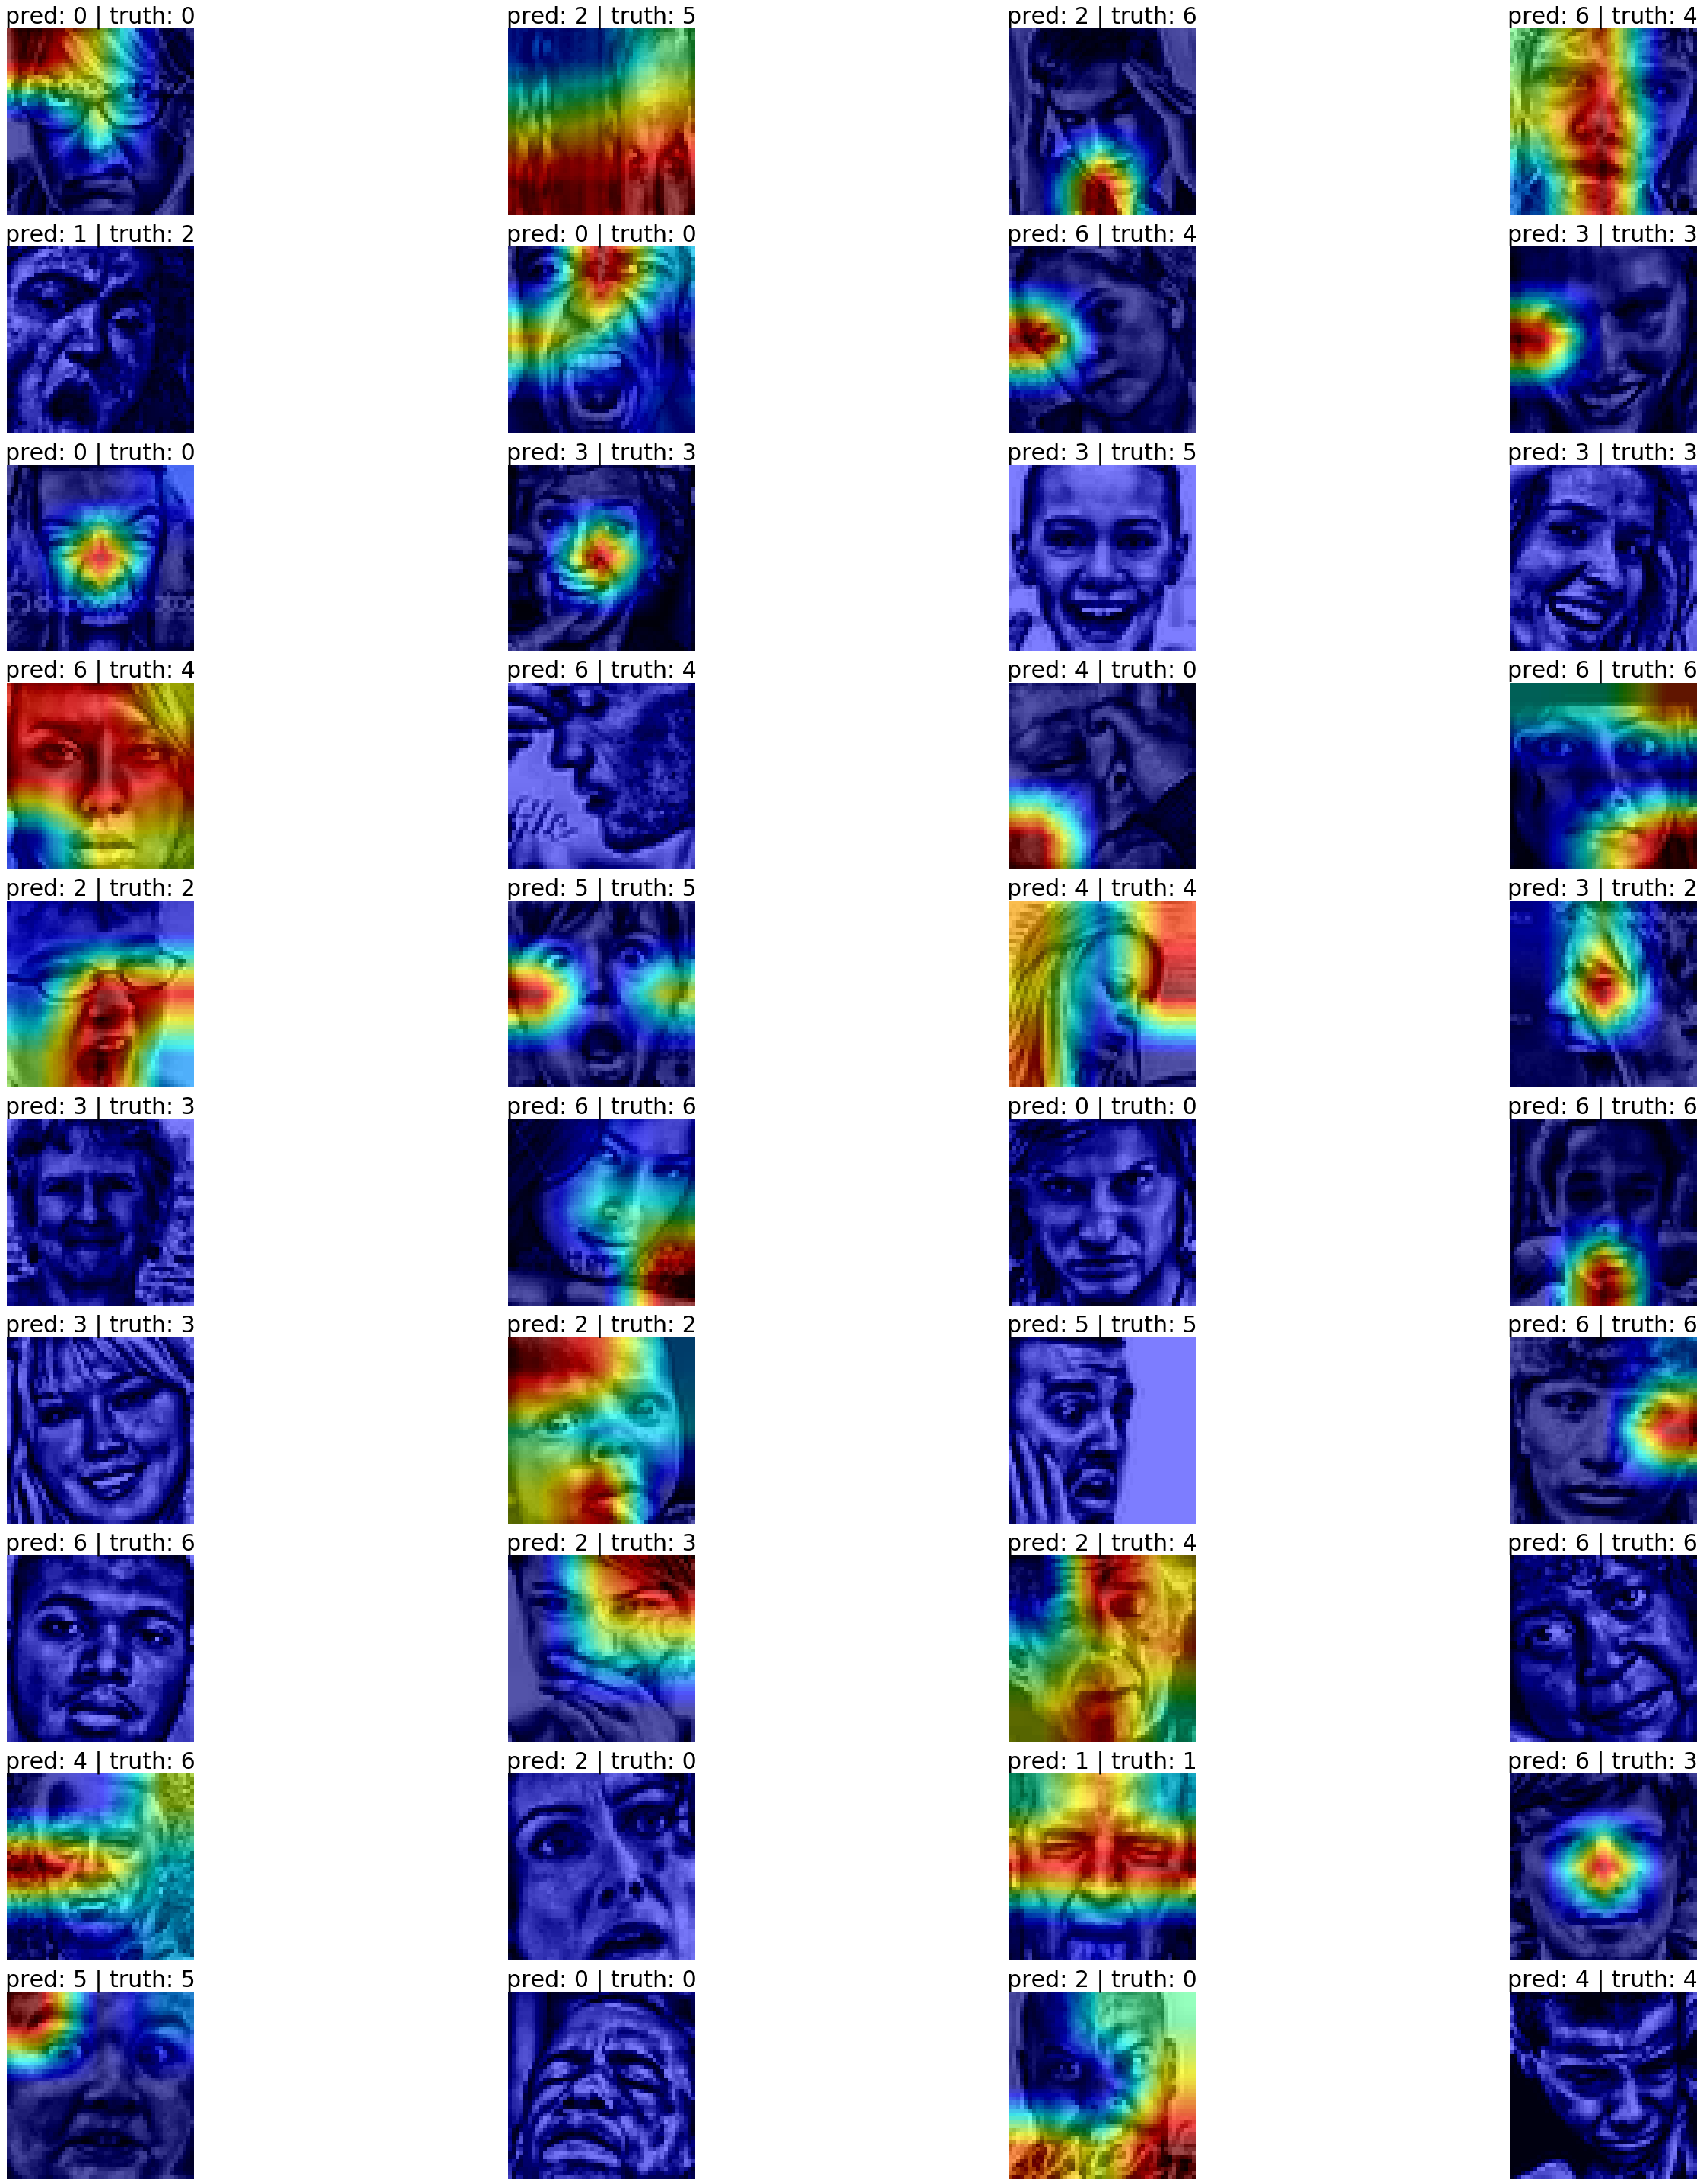

In [192]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## v4 omit HW

In [193]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.dim, self.dim),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

## Omit HW + Non-linear proj, wo ReLU

In [198]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.dim, self.dim),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
    
        # projection
        x_mid = x + cor_feature
        x_out = self.proj_conv(x_mid)
        x_out = x_out + x_mid
        
        x_out = self.out_layernorm(x_out)
        return x

## - Omit non-linear proj with Norm

In [178]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.mid_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.dim, self.dim),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  / math.sqrt(self.dim) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
    
        # projection
        x_mid = x + cor_feature
        x_mid = self.mid_layernorm(x_mid)
        
        x_out = self.proj_conv(x_mid)
        x_out = x_out + x_mid
        
        x_out = self.out_layernorm(x_out)
        return x_out

In [199]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [200]:
model = torch.load('featureactv4_omitHW_projconv_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [201]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

### - omit HW

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

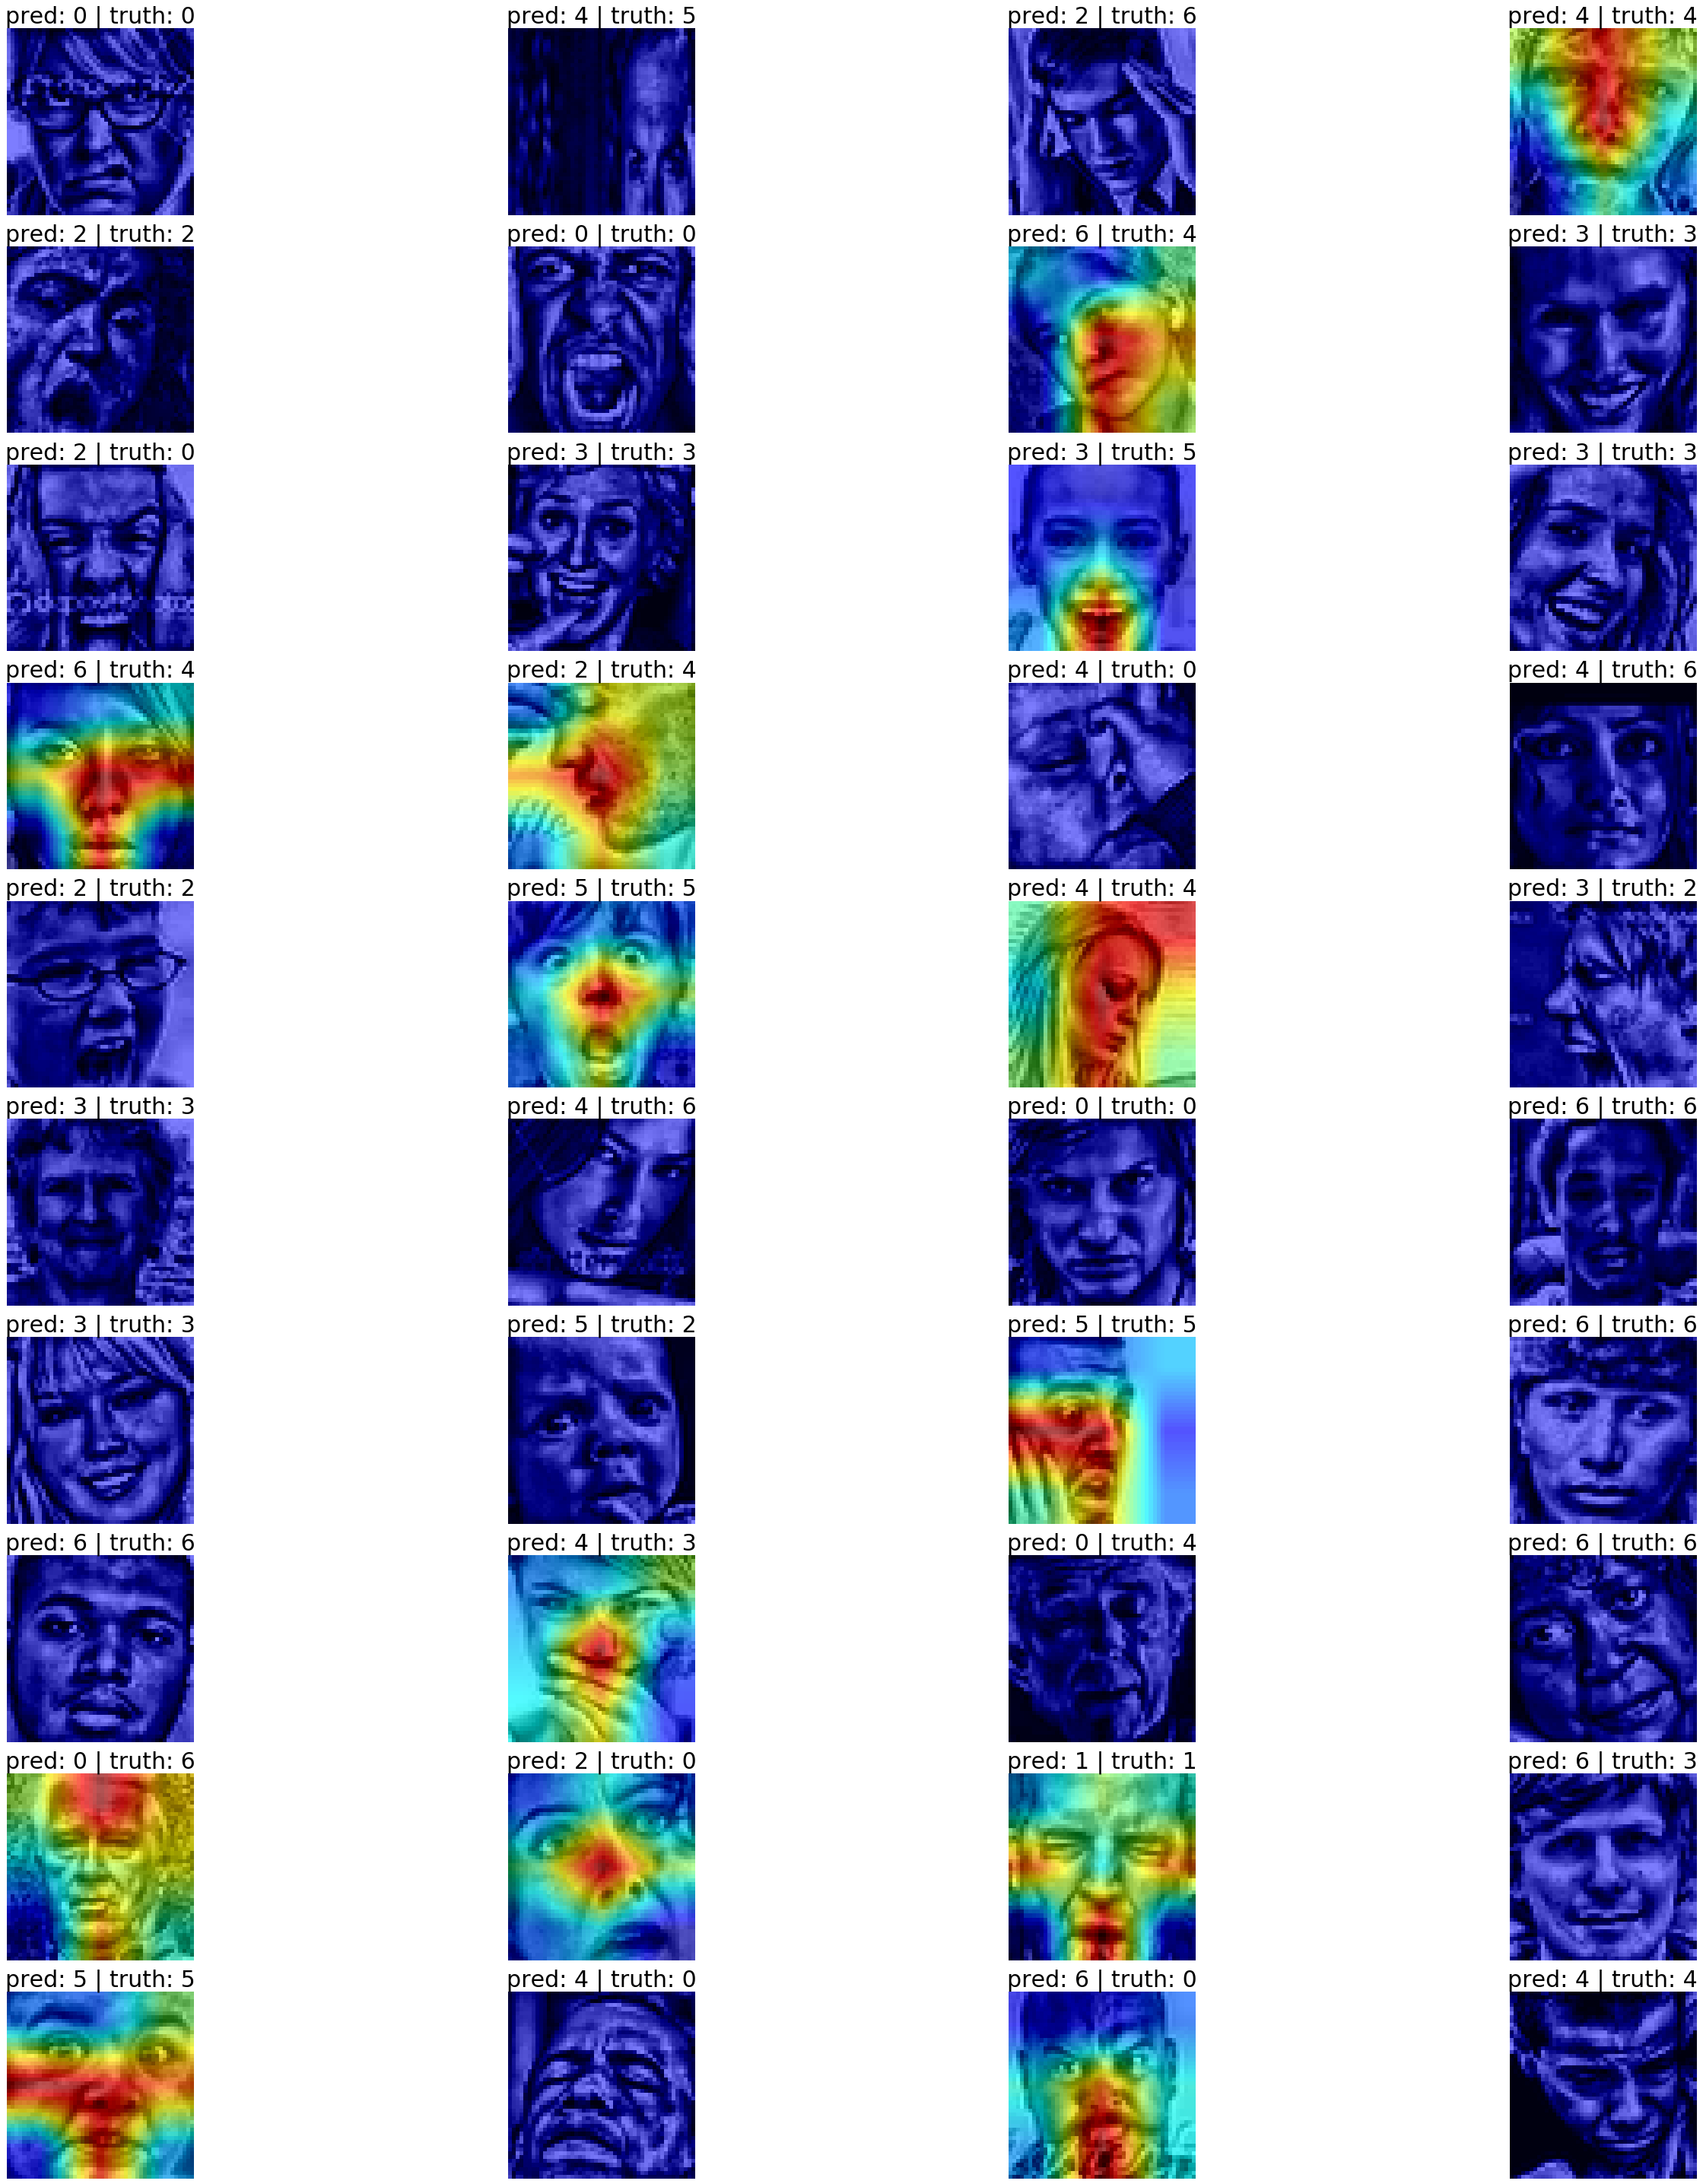

In [197]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

### - omit HW non-linear proj wo ReLU

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

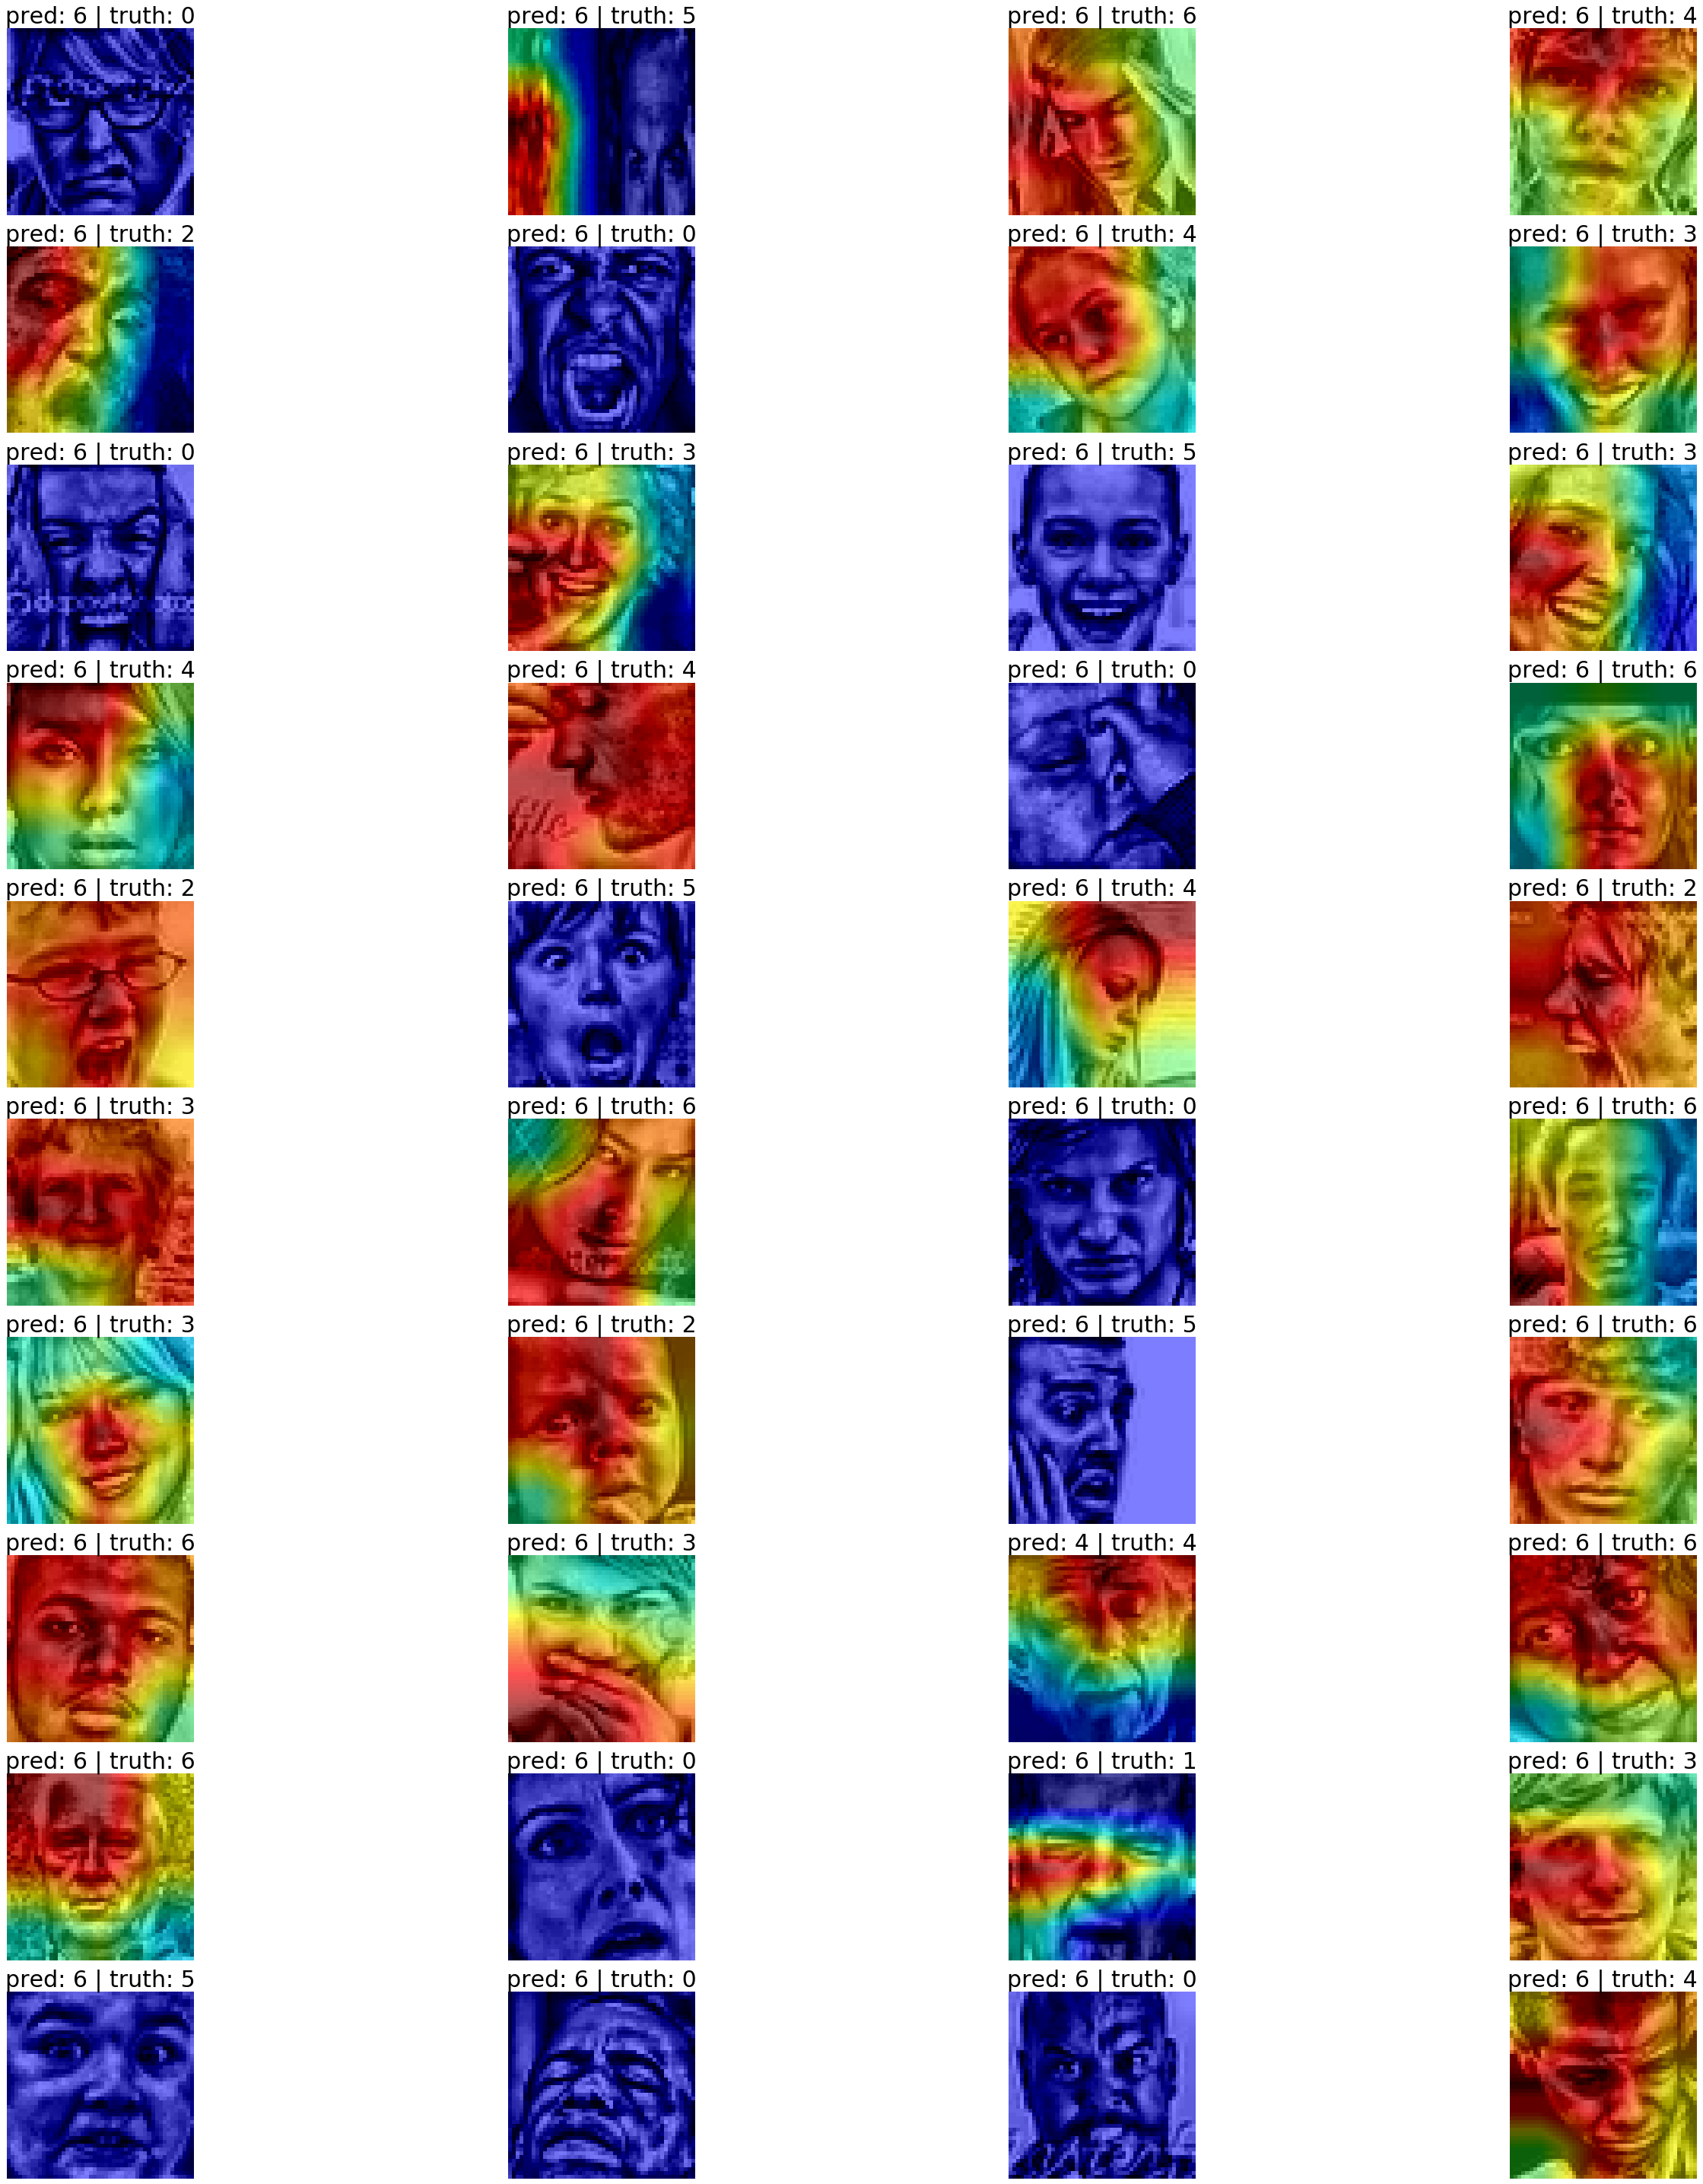

In [202]:
%matplotlib inline

heatmaps = []

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob, hm = attention(model, images[id], labels[id], return_heatmap=True )
        heatmaps.append(hm)
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

### -- 2 facts

In [203]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.mid_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Dropout(dropout), 
                                       nn.Linear(self.dim, self.dim))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        
        self.alpha = Parameter(torch.zeros(1), requires_grad=True)
        self.beta = Parameter(torch.zeros(1), requires_grad=True)
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                    for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
    
        # projection
        x_mid = x + (self.alpha * cor_feature)
        x_mid = self.mid_layernorm(x_mid)
        
        x_out = self.proj_conv(x_mid)
        x_out = x_out + (self.beta * x_mid)
        
        x_out = self.out_layernorm(x_out)
        return x_out

In [204]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

#         self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
#         self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
#         x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
#         x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [205]:
model = torch.load('featureactv4_omitHW_projconv_2facts_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [206]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

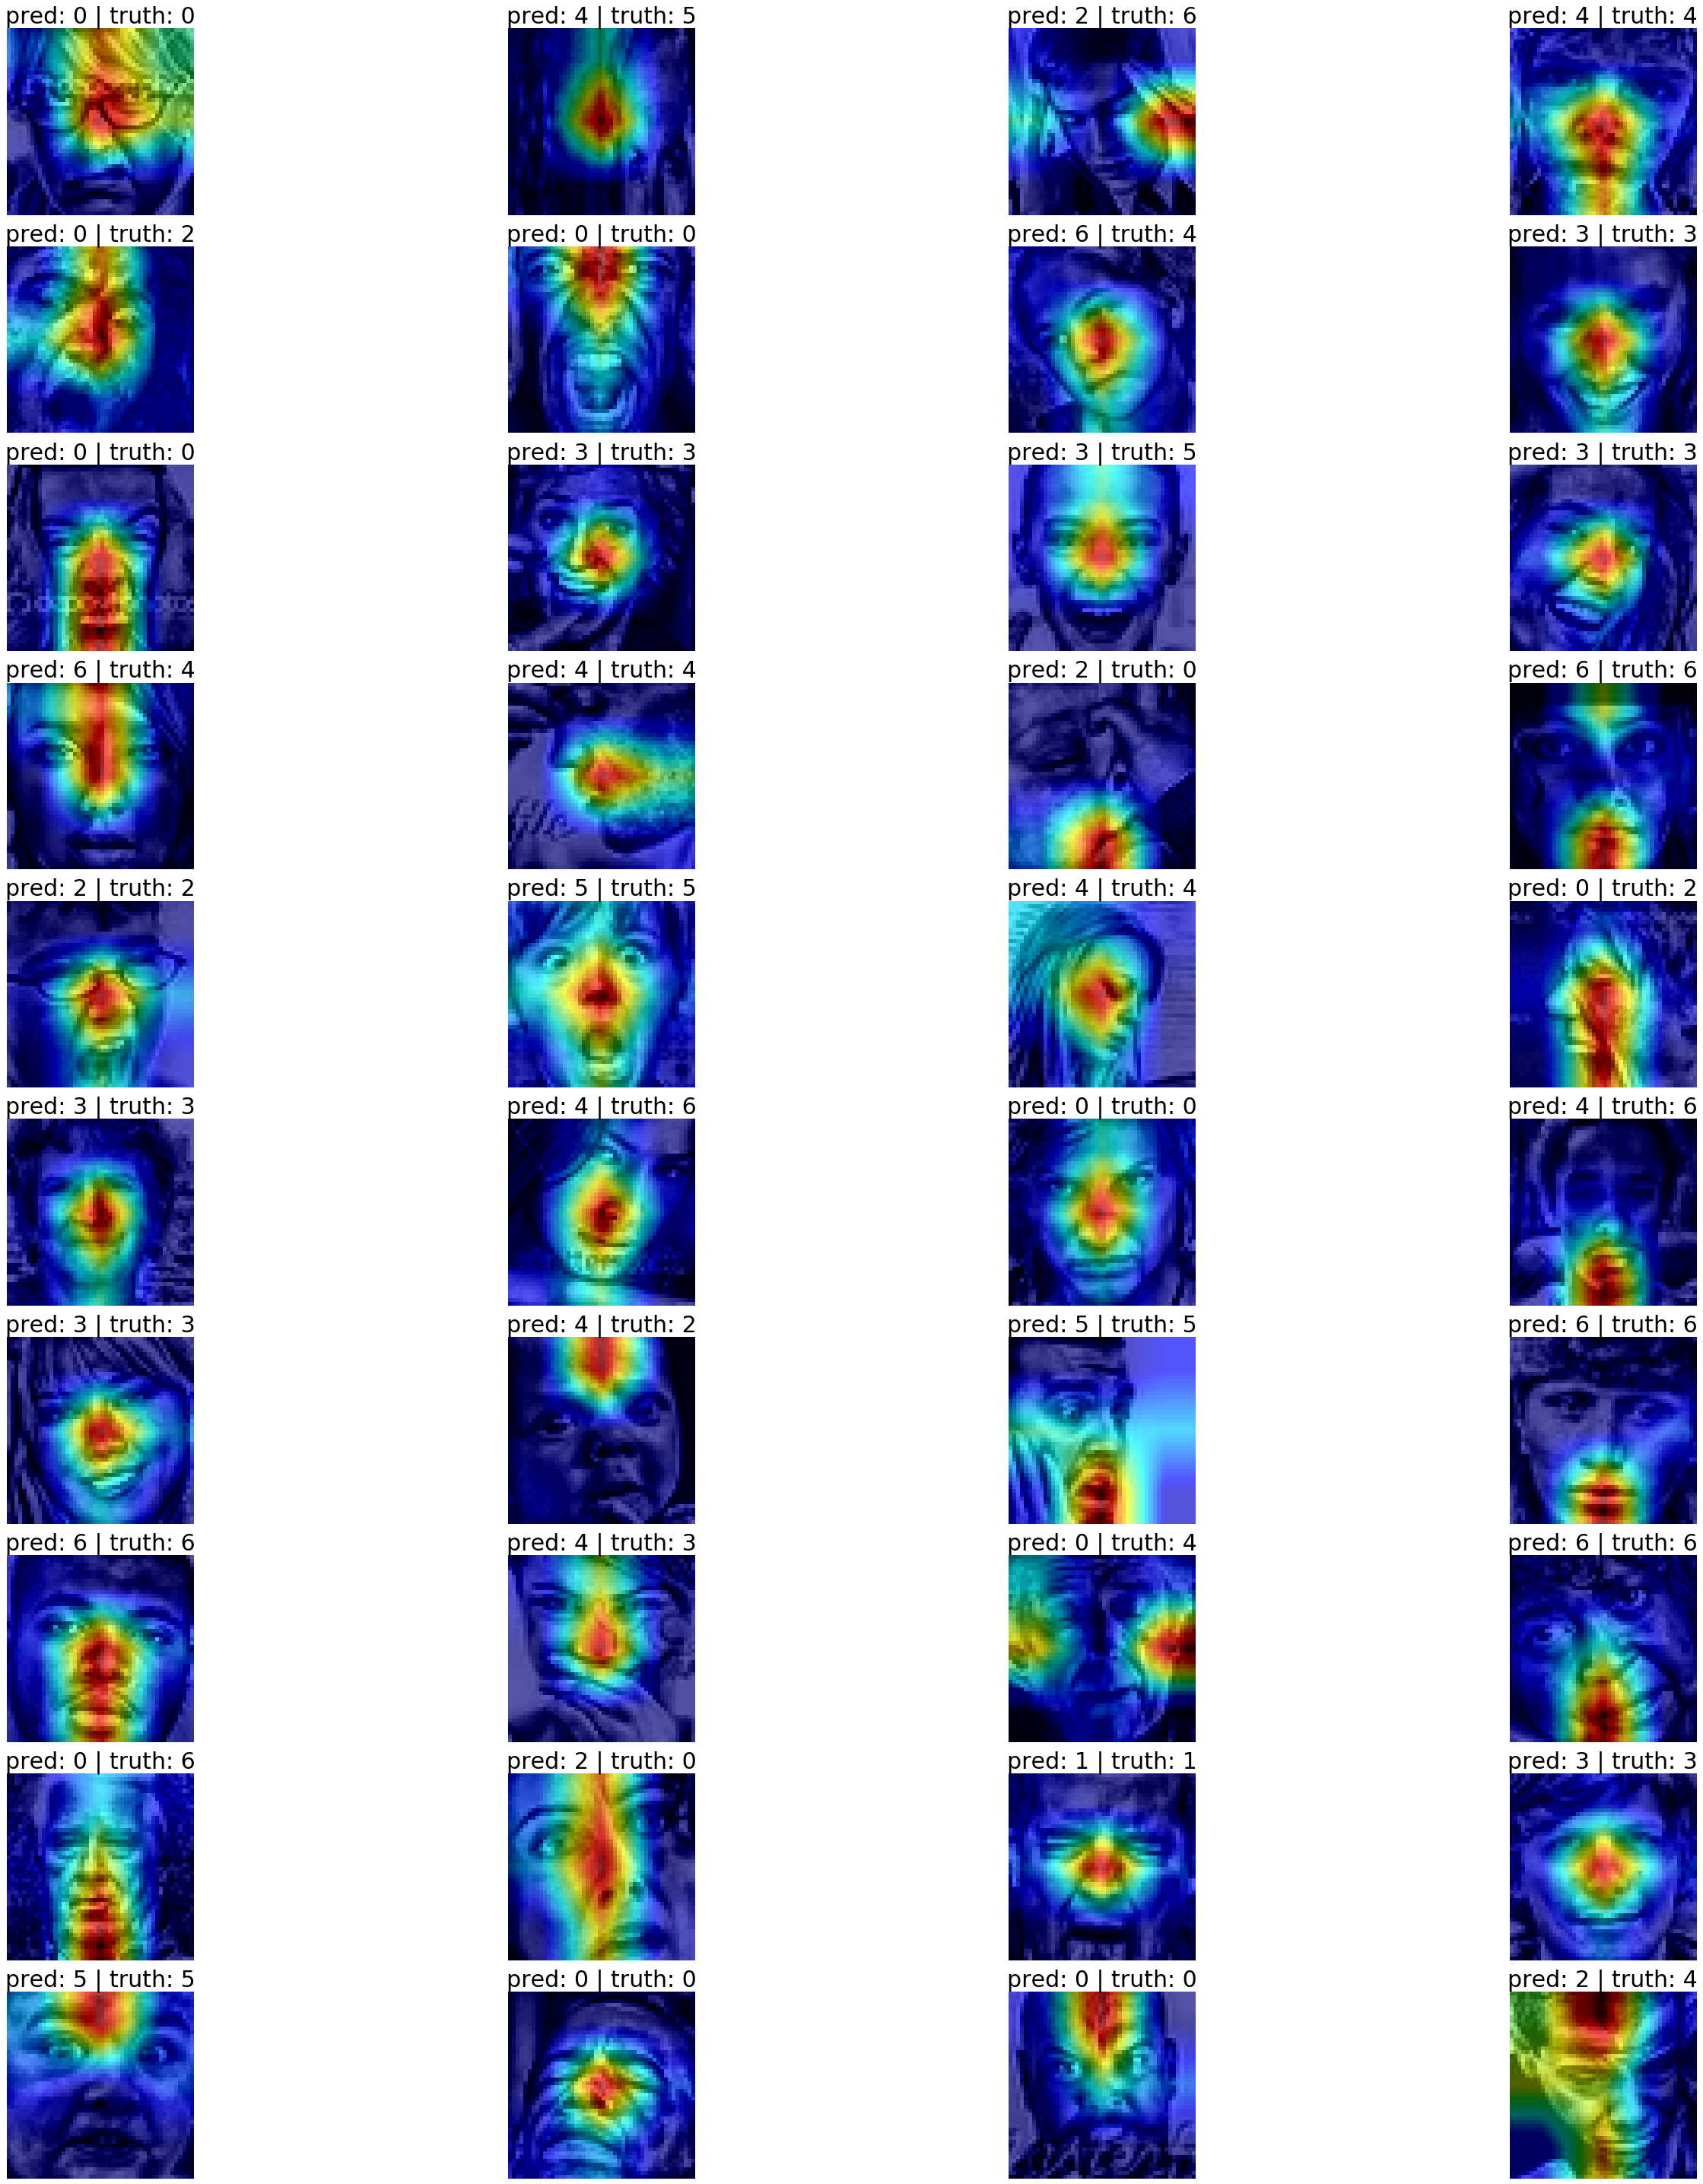

In [207]:
%matplotlib inline

heatmaps = []

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob, hm = attention(model, images[id], labels[id], return_heatmap=True )
        heatmaps.append(hm)
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

In [213]:
model.fact2.alpha, model.fact2.beta, model.fact3.alpha, model.fact3.beta

(Parameter containing:
 tensor([-0.0001], requires_grad=True), Parameter containing:
 tensor([-0.0519], requires_grad=True), Parameter containing:
 tensor([3.4929e-08], requires_grad=True), Parameter containing:
 tensor([-0.0061], requires_grad=True))

Notes: without the presents of alpha and beta, some attention maps are lost

**The fact block just contributes a small part to the main features**

### - omit HW non-linear proj wo ReLU with Norm

In [180]:
model = torch.load('featureactv4_omitHW_projconv_norm_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [181]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

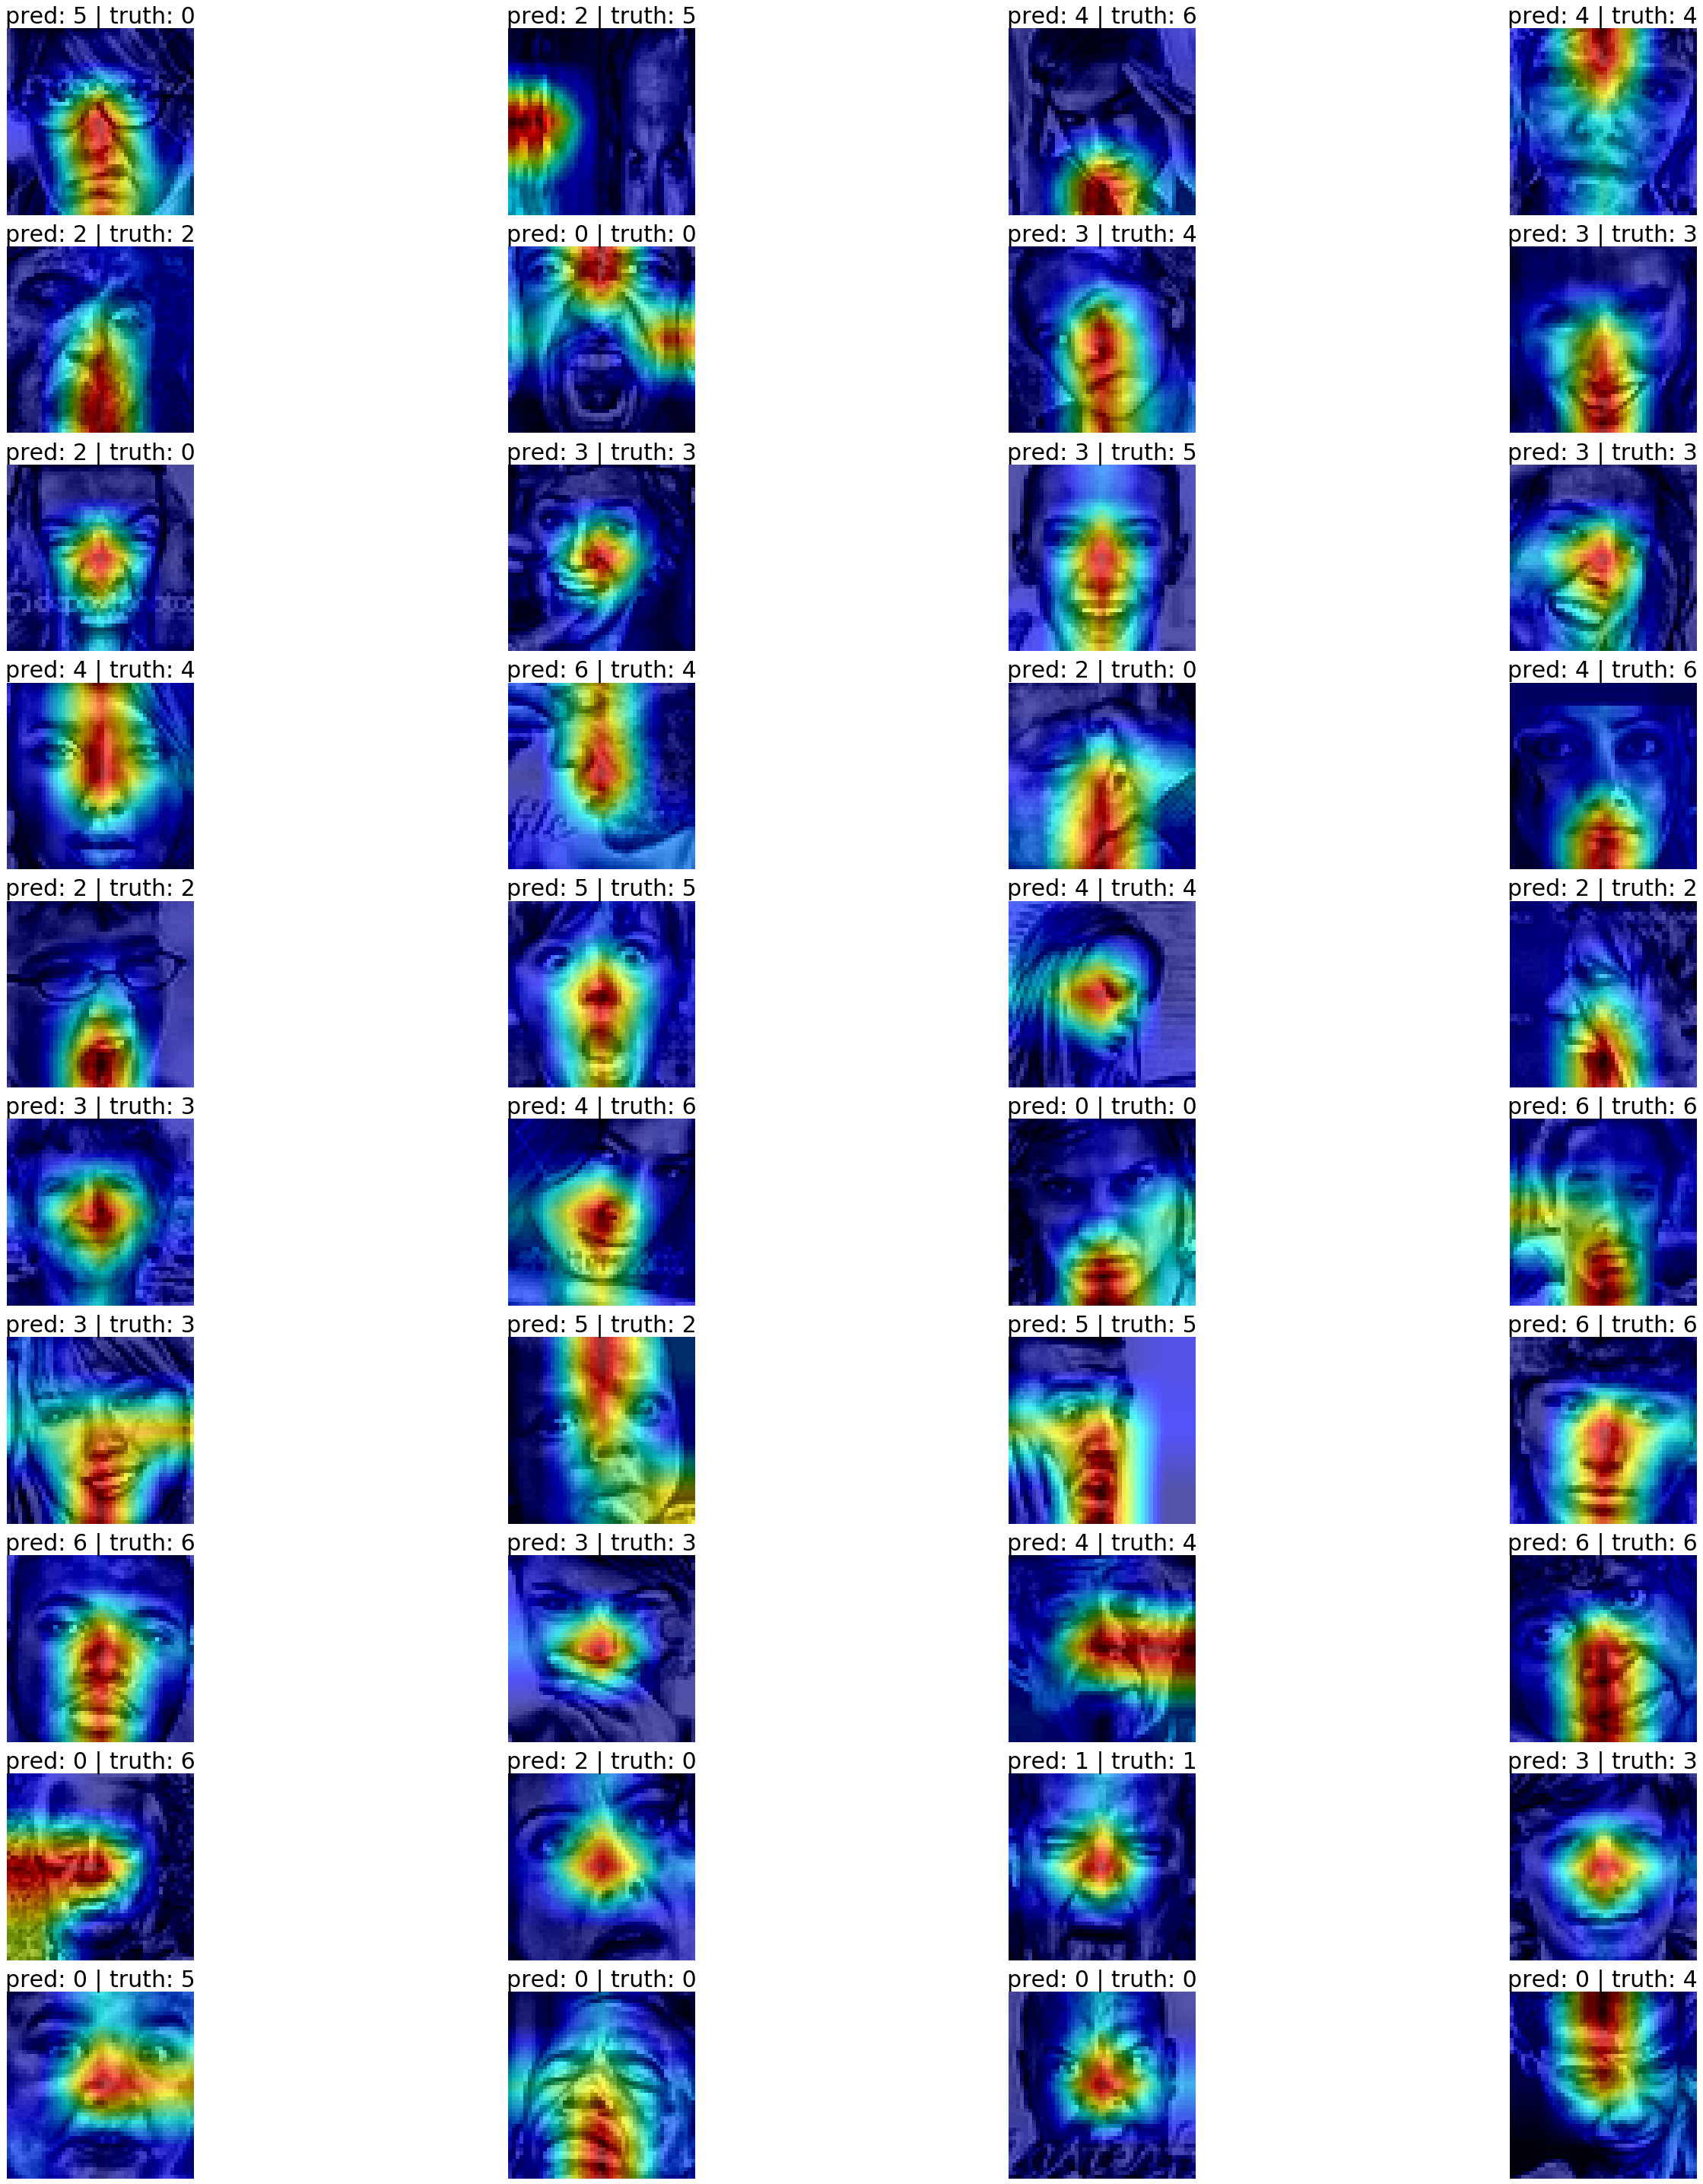

In [182]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## v4 omit D

In [214]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.img_size*self.img_size, self.img_size*self.img_size),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape HWxHW
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size).permute(0,2,1) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size)
        cor = cor / (math.sqrt(self.dim))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)) \
                                  for k in range(self.img_size*self.img_size)], dim=2)
        cor_feature = cor_feature.view(-1, self.dim, self.img_size, self.img_size) # reshape to DxHxW
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [215]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [216]:
model = torch.load('featureactv4_omitD_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [217]:
activation = {}
gradients = {}

# print(model)

model.fact3.register_forward_hook(get_activation('last_conv'))
model.fact3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
Clip

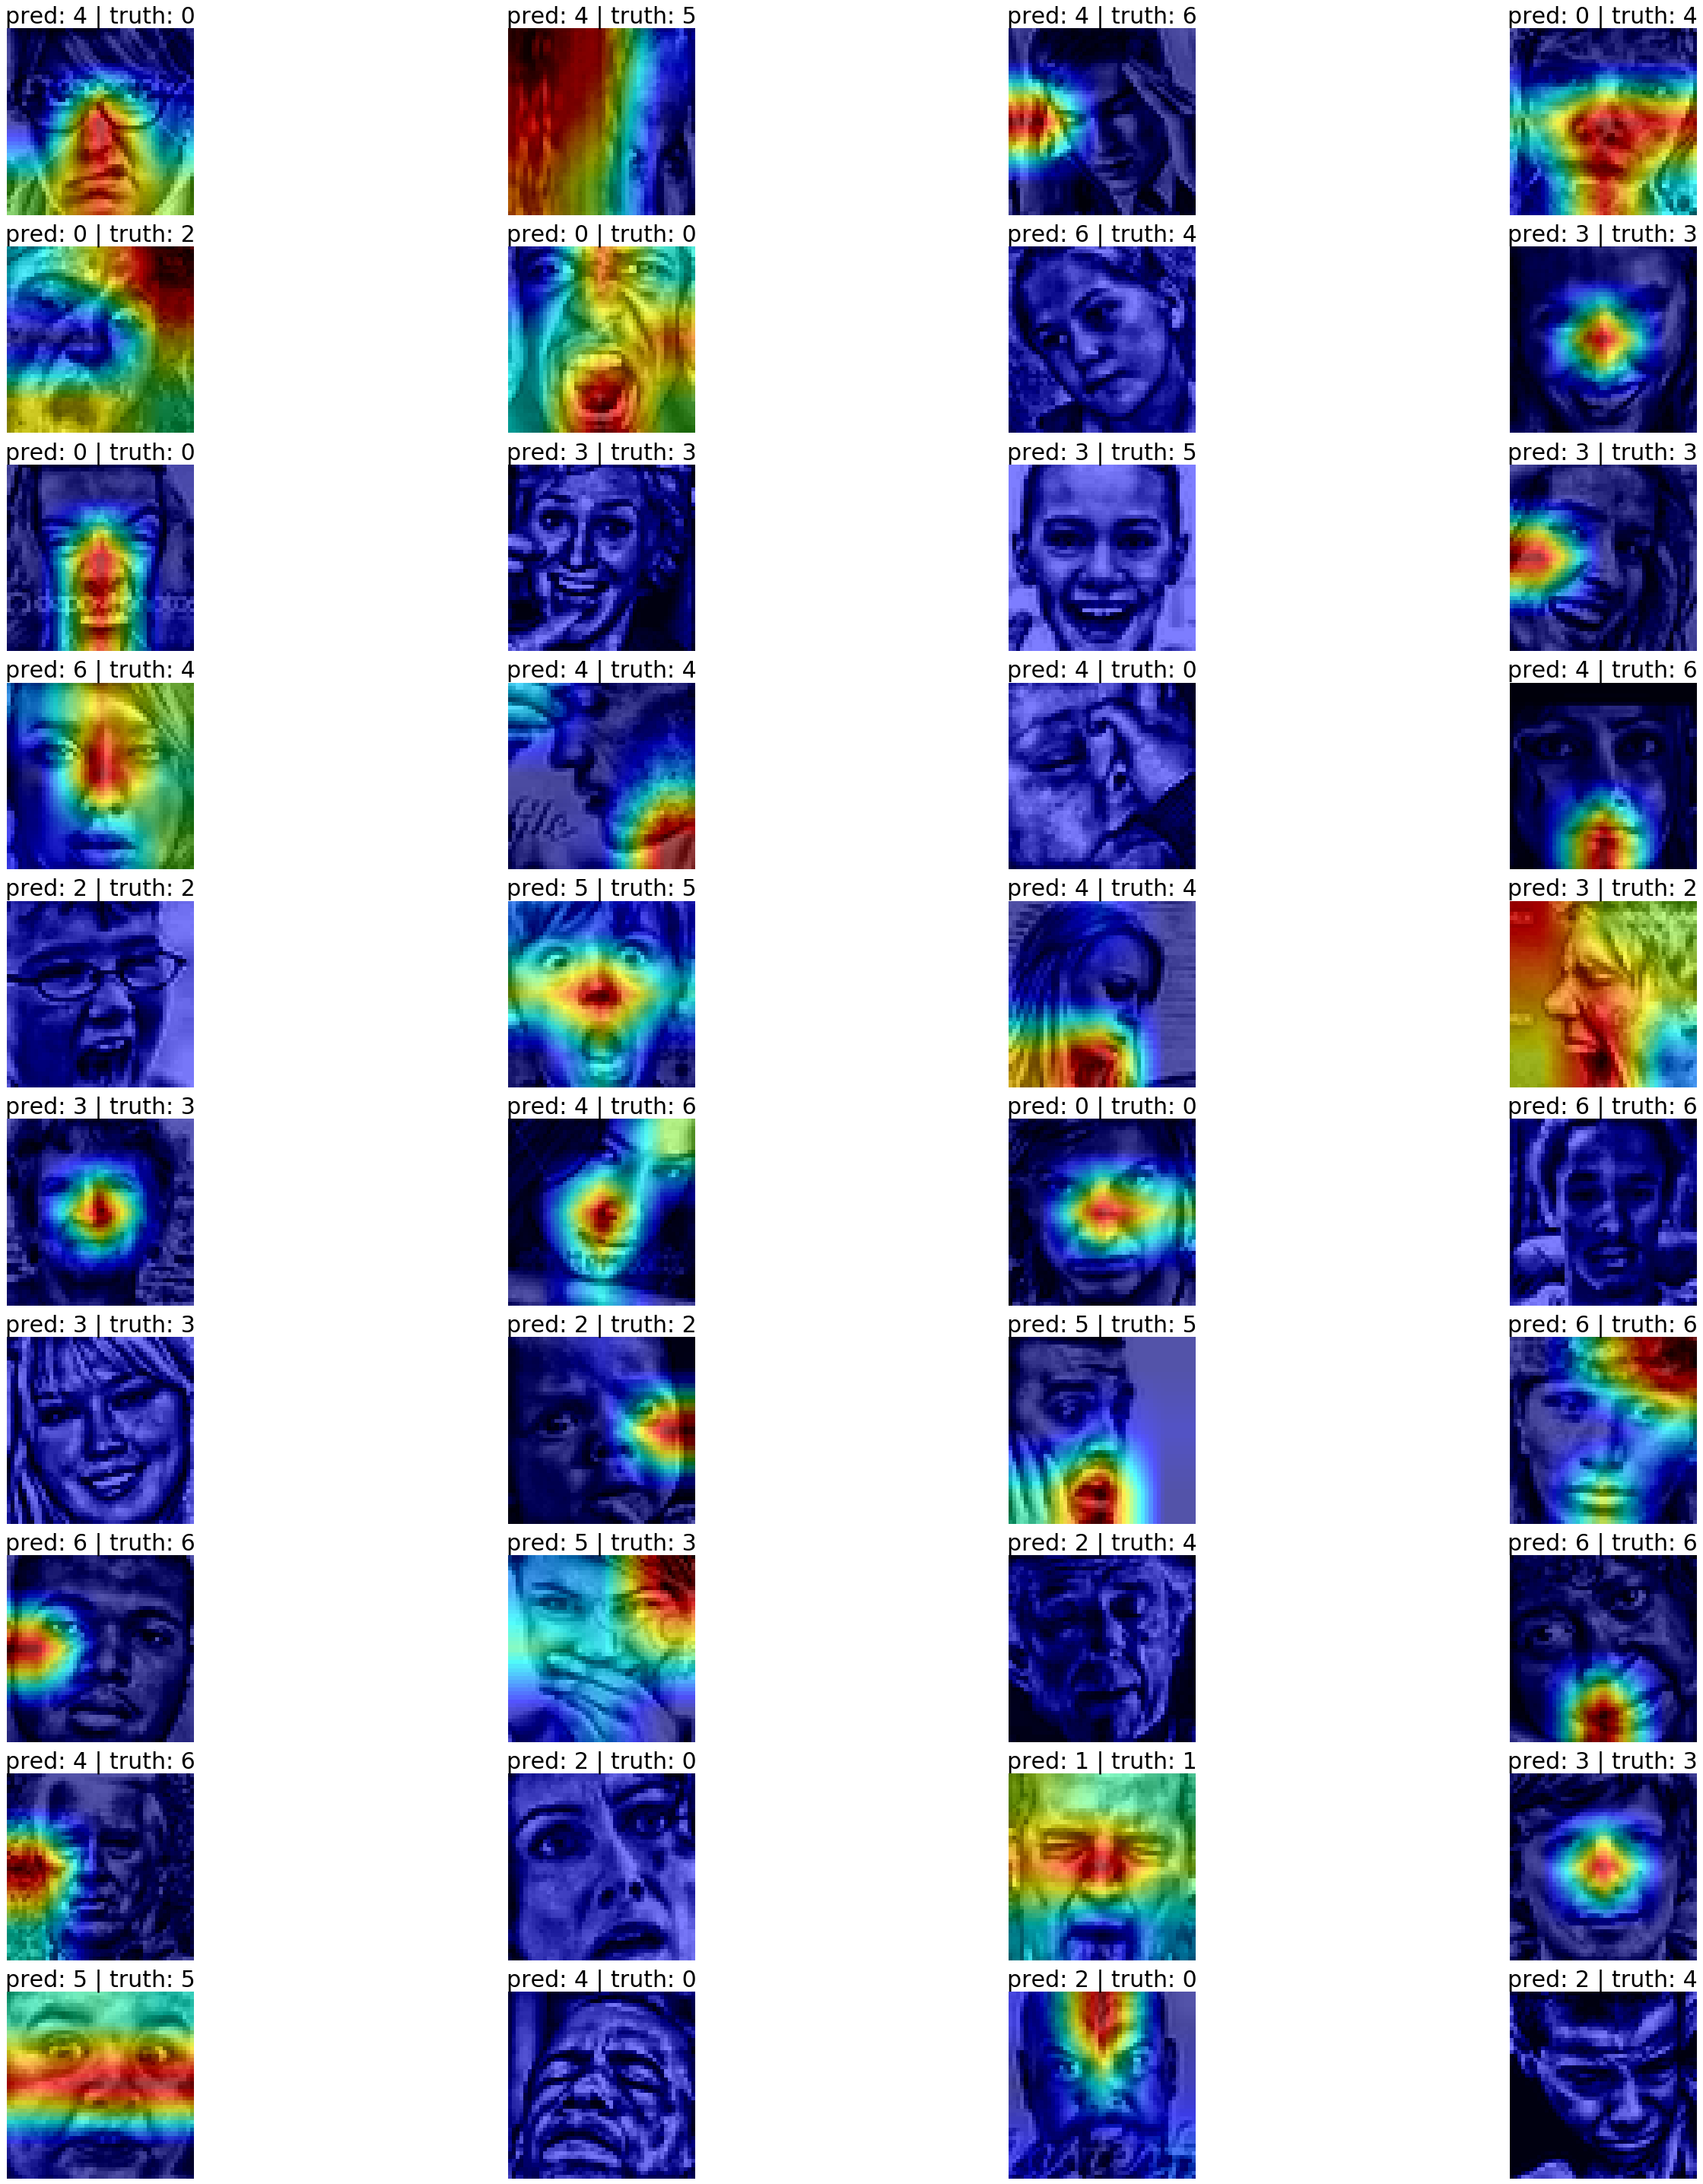

In [218]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

## Combined

In [51]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv_d = nn.Sequential(nn.Dropout(dropout),
                                         nn.Linear(self.dim, self.dim))
        self.norm_conv_hw = nn.Sequential(nn.Dropout(dropout), 
                                          nn.Linear(self.img_size*self.img_size, self.img_size*self.img_size))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor_d = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor_d = cor_d / (math.sqrt(self.img_size * self.img_size))
        cor_feature_d = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv_d(cor_d[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  for k in range(self.dim)], dim=1)
        
        # cor has shape HWxHW
        cor_hw = src_features.view(-1, self.dim, self.img_size * self.img_size).permute(0,2,1) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size)
        cor_hw = cor_hw / (math.sqrt(self.dim))
        cor_feature_hw = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size) \
                                  @ self.norm_conv_hw(cor_hw[:,:,k]).unsqueeze(-1)) \
                                  for k in range(self.img_size*self.img_size)], dim=2)
        cor_feature_hw = cor_feature_hw.view(-1, self.dim, self.img_size, self.img_size) # reshape to DxHxW
        
        cor_feature = cor_feature_d + cor_feature_hw
        cor_feature = self.up_depth(cor_feature)
    
        # projection
        x_mid = x + cor_feature
        x_out = self.proj_conv(x_mid)
        x_out = x_out + x_mid
        
        x_out = self.out_layernorm(x_out)
        
        return x

In [52]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [53]:
model = torch.load('featureactv4_combinedomit_baseline_model.pt')
model = model.cpu()
model.eval()

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

In [54]:
activation = {}
gradients = {}

# print(model)

model.bn3.register_forward_hook(get_activation('last_conv'))
model.bn3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

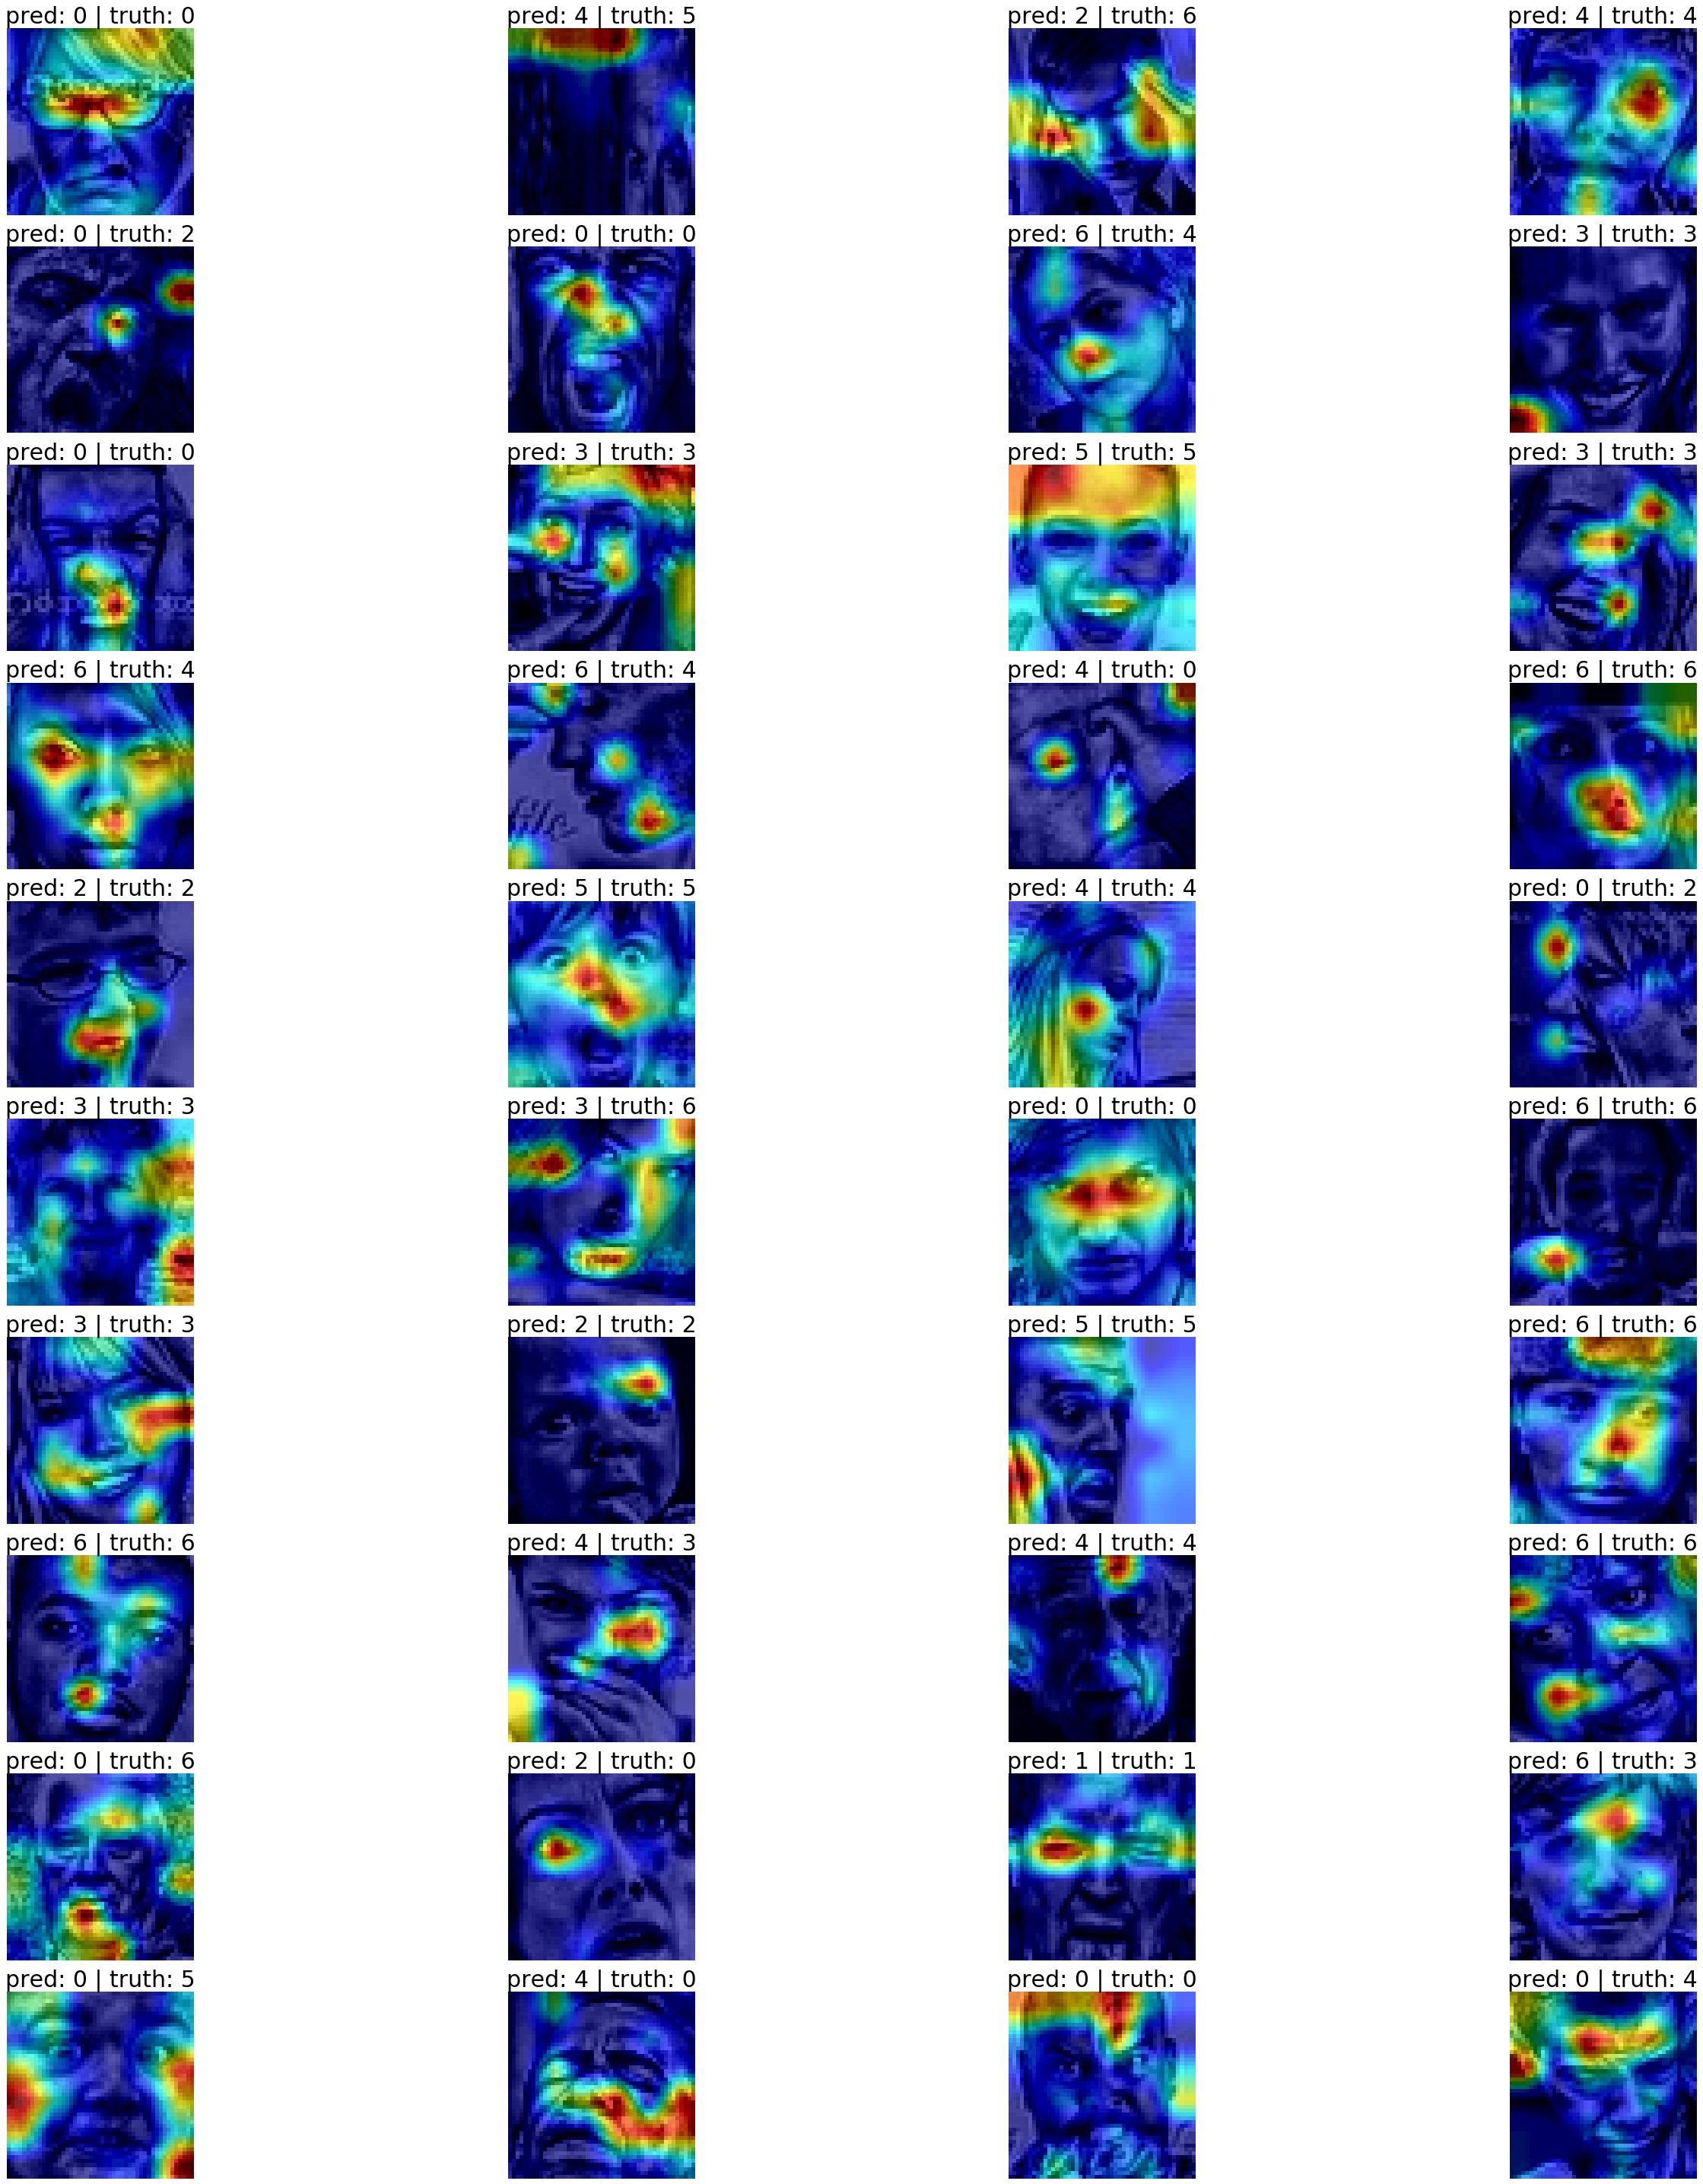

In [55]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()